In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")

In [3]:
data_sources = 'gswp-p_gleam-ep_gswp-t'

## 1. Plot Sr vs descriptors

In [3]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.dropna()
df = df.drop(columns=['stext','start_year','end_year','years','kg'])
df_st = StandardScaler().fit_transform(df) #standardize all values
df_st = pd.DataFrame(df_st)
df_st.index = df.index
df_st.columns = df.columns

In [180]:
# plot sr vs descriptors
def plot_sr_vs_var(df,var1,var2,mode):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(df[var1],df[var2],'go',markersize=1)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    rs = np.corrcoef(df[var1],df[var2])[0,1]**2
    ax.set_title(f'n={len(df[var1])}; r-squared: {np.round(rs,3)}')
    fig.savefig(f'{work_dir}/output/figures/prediction_figures/sr_scatters/{mode}/{var1}_{var2}.jpg', bbox_inches='tight',dpi=300)
    plt.close()
    
def plot_sr_vs_var_tc(df,var1,var2,mode):
    cmap = cm.get_cmap('viridis_r', 21)
    bounds = np.linspace(0,0.5,5)
    bounds2 = np.linspace(0,0.5,5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(13, 6))
    ax1 = plt.subplot(2,4,3)
    ax2 = plt.subplot(2,4,4)
    ax3 = plt.subplot(2,4,7)
    ax4 = plt.subplot(2,4,8)
    ax5 = plt.subplot(1,2,1)
    axes = [ax1, ax2, ax3, ax4,ax5]
    s = ax5.scatter(df[var1],df[var2],c=df['tc'],s=0.5,cmap=cmap,norm=norm)
    cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label='tree cover (-)', size=12)
    ax5.set_xlabel(var1,size=12)
    ax5.set_ylabel(var2,size=12)
    ax1.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax2.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax3.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax4.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax5.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax1.set_ylim(0,900)
    ax2.set_ylim(0,900)
    ax3.set_ylim(0,900)
    ax4.set_ylim(0,900)
    ax5.set_ylim(0,900)
    rs = np.corrcoef(df[var1],df[var2])[0,1]**2
    ax5.set_title(f'n={len(df[var1])}; r-squared: {np.round(rs,3)}')
    ax5.tick_params(labelsize=12)
    ax1.scatter(df[var1][df['tc']<bounds[1]],df[var2][df['tc']<bounds[1]],c=df['tc'][df['tc']<bounds[1]],s=0.5,cmap=cmap,norm=norm)
    ax2.scatter(df[var1][(df['tc']>=bounds[1])&(df['tc']<bounds[2])],df[var2][(df['tc']>=bounds[1])&(df['tc']<bounds[2])],c=df['tc'][(df['tc']>=bounds[1])&(df['tc']<bounds[2])],s=0.5,cmap=cmap,norm=norm)
    ax3.scatter(df[var1][(df['tc']>=bounds[2])&(df['tc']<bounds[3])],df[var2][(df['tc']>=bounds[2])&(df['tc']<bounds[3])],c=df['tc'][(df['tc']>=bounds[2])&(df['tc']<bounds[3])],s=0.5,cmap=cmap,norm=norm)
    ax4.scatter(df[var1][(df['tc']>=bounds[3])],df[var2][(df['tc']>=bounds[3])],c=df['tc'][(df['tc']>=bounds[3])],s=0.5,cmap=cmap,norm=norm)
    fig.savefig(f'{work_dir}/output/figures/prediction_figures/sr_scatters/{mode}/{var1}_{var2}.jpg', bbox_inches='tight',dpi=300)
    plt.close()
    
def plot_sr_vs_var_ntc(df,var1,var2,mode):
    cmap = cm.get_cmap('viridis', 21)
    bounds = np.linspace(0.3,0.8,5)
    bounds2 = np.linspace(0.3,0.8,5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(13, 6))
    ax1 = plt.subplot(2,4,3)
    ax2 = plt.subplot(2,4,4)
    ax3 = plt.subplot(2,4,7)
    ax4 = plt.subplot(2,4,8)
    ax5 = plt.subplot(1,2,1)
    axes = [ax1, ax2, ax3, ax4,ax5]
    s = ax5.scatter(df[var1],df[var2],c=df['ntc'],s=0.5,cmap=cmap,norm=norm)
    cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label='non tree cover (-)', size=12)
    ax5.set_xlabel(var1,size=12)
    ax5.set_ylabel(var2,size=12)
    ax1.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax2.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax3.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax4.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax5.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax1.set_ylim(0,900)
    ax2.set_ylim(0,900)
    ax3.set_ylim(0,900)
    ax4.set_ylim(0,900)
    ax5.set_ylim(0,900)
    rs = np.corrcoef(df[var1],df[var2])[0,1]**2
    ax5.set_title(f'n={len(df[var1])}; r-squared: {np.round(rs,3)}')
    ax5.tick_params(labelsize=12)
    ax1.scatter(df[var1][df['ntc']<bounds[1]],df[var2][df['ntc']<bounds[1]],c=df['ntc'][df['ntc']<bounds[1]],s=0.5,cmap=cmap,norm=norm)
    ax2.scatter(df[var1][(df['ntc']>=bounds[1])&(df['ntc']<bounds[2])],df[var2][(df['ntc']>=bounds[1])&(df['ntc']<bounds[2])],c=df['ntc'][(df['ntc']>=bounds[1])&(df['ntc']<bounds[2])],s=0.5,cmap=cmap,norm=norm)
    ax3.scatter(df[var1][(df['ntc']>=bounds[2])&(df['ntc']<bounds[3])],df[var2][(df['ntc']>=bounds[2])&(df['ntc']<bounds[3])],c=df['ntc'][(df['ntc']>=bounds[2])&(df['ntc']<bounds[3])],s=0.5,cmap=cmap,norm=norm)
    ax4.scatter(df[var1][(df['ntc']>=bounds[3])],df[var2][(df['ntc']>=bounds[3])],c=df['ntc'][(df['ntc']>=bounds[3])],s=0.5,cmap=cmap,norm=norm)
    fig.savefig(f'{work_dir}/output/figures/prediction_figures/sr_scatters/{mode}/{var1}_{var2}.jpg', bbox_inches='tight',dpi=300)
    plt.close()
    
def plot_sr_vs_var_ai(df,var1,var2,mode):
    cmap = cm.get_cmap('viridis', 21)
    bounds = np.linspace(0,2,5)
    bounds2 = np.linspace(0,2,5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(13, 6))
    ax1 = plt.subplot(2,4,3)
    ax2 = plt.subplot(2,4,4)
    ax3 = plt.subplot(2,4,7)
    ax4 = plt.subplot(2,4,8)
    ax5 = plt.subplot(1,2,1)
    axes = [ax1, ax2, ax3, ax4,ax5]
    s = ax5.scatter(df[var1],df[var2],c=df['ai'],s=0.5,cmap=cmap,norm=norm)
    cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label='aridity index', size=12)
    ax5.set_xlabel(var1,size=12)
    ax5.set_ylabel(var2,size=12)
    ax1.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax2.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax3.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax4.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax5.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax1.set_ylim(0,900)
    ax2.set_ylim(0,900)
    ax3.set_ylim(0,900)
    ax4.set_ylim(0,900)
    ax5.set_ylim(0,900)
    rs = np.corrcoef(df[var1],df[var2])[0,1]**2
    ax5.set_title(f'n={len(df[var1])}; r-squared: {np.round(rs,3)}')
    ax5.tick_params(labelsize=12)
    ax1.scatter(df[var1][df['ai']<bounds[1]],df[var2][df['ai']<bounds[1]],c=df['ai'][df['ai']<bounds[1]],s=0.5,cmap=cmap,norm=norm)
    ax2.scatter(df[var1][(df['ai']>=bounds[1])&(df['ai']<bounds[2])],df[var2][(df['ai']>=bounds[1])&(df['ai']<bounds[2])],c=df['ai'][(df['ai']>=bounds[1])&(df['ai']<bounds[2])],s=0.5,cmap=cmap,norm=norm)
    ax3.scatter(df[var1][(df['ai']>=bounds[2])&(df['ai']<bounds[3])],df[var2][(df['ai']>=bounds[2])&(df['ai']<bounds[3])],c=df['ai'][(df['ai']>=bounds[2])&(df['ai']<bounds[3])],s=0.5,cmap=cmap,norm=norm)
    ax4.scatter(df[var1][(df['ai']>=bounds[3])],df[var2][(df['ai']>=bounds[3])],c=df['ai'][(df['ai']>=bounds[3])],s=0.5,cmap=cmap,norm=norm)
    fig.savefig(f'{work_dir}/output/figures/prediction_figures/sr_scatters/{mode}/{var1}_{var2}.jpg', bbox_inches='tight',dpi=300)
    plt.close()

In [5]:
var = df.columns
for i in var:
    plot_sr_vs_var(df,i,'sr_20','keep_units')
    plot_sr_vs_var(df_st,i,'sr_20','standardized')
    plot_sr_vs_var_tc(df,i,'sr_20','tree_cover')
    plot_sr_vs_var_ntc(df,i,'sr_20','non_tree_cover')
    plot_sr_vs_var_ai(df,i,'sr_20','aridity_index')

## CORRELATION MATRIX

In [12]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.dropna()
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l'])
df = df.drop(columns=['ai','sti','area'])
df = df.drop(columns=['q_mean'])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')

/tmp/ipykernel_122/3019430927.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)
/tmp/ipykernel_122/3019430927.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')


## 2. PCA + clusters

In [110]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.dropna()
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l'])
df = df.drop(columns=['q_mean'])
df

p_mean   ep_mean     t_mean        ai       hai  tdiff_max  \
br_0003200  5.303953  2.608627  19.857762  0.491827  0.604298  14.268765   
ca_0002351  1.590253  1.401269   0.643260  0.881161  0.419085  32.852726   
fr_0001142  2.989535  1.520868  10.193313  0.508730  0.563267  23.400001   
br_0001524  4.594565  2.985874  19.671313  0.649871  0.691181  10.875286   
in_0000027  3.368431  2.750685  25.678652  0.816607  1.198574  17.669193   
...              ...       ...        ...       ...       ...        ...   
gb_0000090  2.150804  1.572770  10.290431  0.731247  0.776424  18.325000   
229661A     3.269137  2.950922  11.876446  0.902661  0.586347  15.333334   
br_0000871  4.374842  2.735070  22.204727  0.625182  0.819372   7.895573   
gb_0000104  2.294868  1.268865  10.186598  0.552914  0.720360  17.800003   
fr_0000908  2.351888  1.305074  10.705688  0.554905  0.743794  21.931416   

            tdiff_mean  idu_mean  idu_max  hpd_mean  ...   slp_std       iwu  \
br_0003200   12.021896      4.21    16.93      1.22  ...  3.590448  0.100052   
ca_0002351   25.221876      5.05    22.43      1.35  ...  7.937310  0.000692   
fr_0001142   19.250000      3.87    20.35      1.15  ...  1.086816  0.000000   
br_0001524    7.688446      3.35    18.23      1.23  ...  2.908957  0.004303   
in_0000027   15.270651     17.75    72.93      1.77  ...  1.251385  0.094199   
...                ...       ...      ...       ...  ...       ...       ...   
gb_0000090   14.624166      3.88    22.30      1.12  ...  1.305189  0.001370   
229661A      12.496111      3.64    17.63      1.15  ...  2.799325  0.000000   
br_0000871    6.125985      5.96    53.53      1.37  ...  1.406948  0.004821   
gb_0000104   14.266667      3.77    22.73      1.13  ...  0.662397  0.000351   
fr_0000908   17.394400      4.07    20.93      1.17  ...  1.047771  0.032541   

                  ia        bp    dtb      pclay      psand     pcarb  \
br_0003200  0.095052  0.000000  13.89  36.399144  37.698498  2.198518   
ca_0002351  0.003286  0.069907  19.41  17.094944  45.838508  4.124604   
fr_0001142  0.000147  0.000000  15.27  28.276790  28.212561  2.762086   
br_0001524  0.004408  0.000000  18.95  43.042378  38.771631  3.079075   
in_0000027  0.016516  0.003903  22.31  39.763032  35.817680  1.576522   
...              ...       ...    ...        ...        ...       ...   
gb_0000090  0.000274  0.000000   8.63  19.798915  38.049589  3.841592   
229661A     0.000000  0.000000   3.88  25.550696  53.458085  7.154145   
br_0000871  0.002569  0.000000  24.83  45.266696  38.176125  2.532475   
gb_0000104  0.004777  0.000000   9.95  26.563523  30.053947  3.540056   
fr_0000908  0.051766  0.000000  16.53  24.777050  26.730438  2.485840   

                  bulk       sr_20  
br_0003200  132.033822  123.596026  
ca_0002351  134.041930   85.414394  
fr_0001142  141.694949  197.286771  
br_0001524  115.424594  160.222472  
in_0000027  156.472020  396.277444  
...                ...         ...  
gb_0000090  135.921367  117.701360  
229661A     114.292085  189.439878  
br_0000871  113.757366  203.656842  
gb_0000104  139.665966   55.107518  
fr_0000908  141.444606  185.321810  

[4575 rows x 48 columns]

In [111]:
features = df.columns
lf = len(features)
print('length of features:', lf)
X = df[features]
X = X.dropna()
X = StandardScaler().fit_transform(X) #standardize all values
X = pd.DataFrame(X,columns=features)

pca = PCA(n_components=lf)
components = pca.fit_transform(X)

loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])

length of features: 48


In [112]:
pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
per_var

array([21.1, 12.8, 11.6,  5.5,  4.4,  4.2,  3.6,  3. ,  2.7,  2.6,  2.5,
        2.3,  2.2,  2.1,  2. ,  1.6,  1.5,  1.5,  1.3,  1.3,  1.2,  1.1,
        0.9,  0.9,  0.8,  0.7,  0.6,  0.6,  0.5,  0.4,  0.4,  0.4,  0.3,
        0.2,  0.2,  0.2,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0. ,
        0. ,  0. ,  0. ,  0. ])

In [113]:
ld_df = pd.DataFrame(index=features, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)
# ld_df

In [114]:
ld_sort = abs(ld_df).sort_values('xs',ascending=False)
ld_sort = ld_sort[0:20]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['len','ys'])
ld_sort

xs  rank
t_mean      0.278605     1
si_ep       0.260555     2
tdiff_max   0.257679     3
tdiff_mean  0.254103     4
ep_mean     0.244579     5
si_p        0.240678     6
ftf         0.239306     7
hpd_mean    0.237610     8
idu_max     0.228780     9
pclay       0.216777    10
hpd_max     0.209237    11
dt          0.192930    12
pcarb       0.188313    13
sr_20       0.185882    14
cvp         0.181396    15
idu_mean    0.173466    16
ntc         0.172923    17
hai         0.161630    18
tc          0.156085    19
dtb         0.111309    20

In [115]:
ld_sort = abs(ld_df).sort_values('ys',ascending=False)
ld_sort = ld_sort[0:20]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['len','xs'])
ld_sort

ys  rank
lpf         0.365286     1
p_mean      0.312642     2
nonveg      0.291055     3
hpf         0.261865     4
bulk        0.244194     5
idu_mean    0.236869     6
tc          0.204042     7
hai         0.203486     8
hpd_max     0.196866     9
cvp         0.192101    10
tdiff_mean  0.188383    11
tdiff_max   0.178027    12
si_ep       0.174931    13
idu_max     0.167972    14
pclay       0.153374    15
ep_mean     0.152202    16
dt          0.151034    17
hpd_mean    0.149432    18
asi         0.141871    19
t_mean      0.114289    20

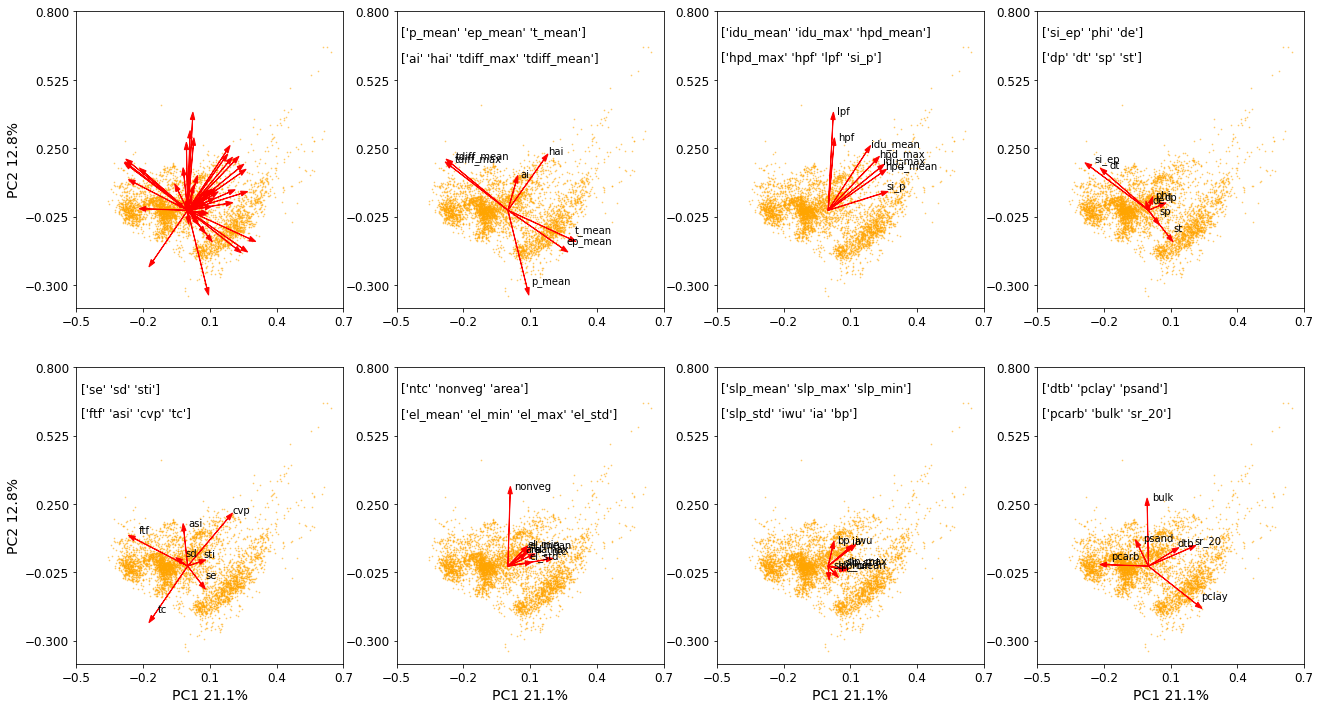

In [116]:
xs = loadings[0]
ys = loadings[1]

# split features for visualization of PCA
p = int(np.round((lf/7),0))
features1=features[0:p]
features2=features[p:2*p]
features3=features[2*p:3*p]
features4=features[3*p:4*p]
features5=features[4*p:5*p]
features6=features[5*p:6*p]
features7=features[6*p:]

fig=plt.figure(figsize=(22,12))
ax = fig.add_subplot(241)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')

for i, varnames in enumerate(features):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features[i]]['xs'], # length of the arrow along x
        ld_df.loc[features[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    # ax.text(ld_df.loc[features[i]]['xs']+0.02, ld_df.loc[features[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_xlabel(f'PC1 {per_var[0]}%')
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)

ax = fig.add_subplot(242)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features1):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features1[i]]['xs'], # length of the arrow along x
        ld_df.loc[features1[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features1[i]]['xs']+0.02, ld_df.loc[features1[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features1[0:int(len(features1)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features1[int(len(features1)/2):].values}',size=12)

ax = fig.add_subplot(243)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features2):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features2[i]]['xs'], # length of the arrow along x
        ld_df.loc[features2[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features2[i]]['xs']+0.02, ld_df.loc[features2[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features2[0:int(len(features2)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features2[int(len(features2)/2):].values}',size=12)

ax = fig.add_subplot(244)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features3):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features3[i]]['xs'], # length of the arrow along x
        ld_df.loc[features3[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features3[i]]['xs']+0.02, ld_df.loc[features3[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features3[0:int(len(features3)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features3[int(len(features3)/2):].values}',size=12)

ax = fig.add_subplot(245)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features4):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features4[i]]['xs'], # length of the arrow along x
        ld_df.loc[features4[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features4[i]]['xs']+0.02, ld_df.loc[features4[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
ax.text(-0.48,0.7,f'{features4[0:int(len(features4)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features4[int(len(features4)/2):].values}',size=12)

ax = fig.add_subplot(246)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features5):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features5[i]]['xs'], # length of the arrow along x
        ld_df.loc[features5[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features5[i]]['xs']+0.02, ld_df.loc[features5[i]]['ys']+0.02, varnames,size=10) 
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features5[0:int(len(features5)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features5[int(len(features5)/2):].values}',size=12)

ax = fig.add_subplot(247)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features6):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features6[i]]['xs'], # length of the arrow along x
        ld_df.loc[features6[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features6[i]]['xs']+0.02, ld_df.loc[features6[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features6[0:int(len(features6)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features6[int(len(features6)/2):].values}',size=12)

ax = fig.add_subplot(248)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features7):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features7[i]]['xs'], # length of the arrow along x
        ld_df.loc[features7[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features7[i]]['xs']+0.02, ld_df.loc[features7[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features7[0:int(len(features7)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features7[int(len(features7)/2):].values}',size=12)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters.jpg',bbox_inches='tight',dpi=300)


In [117]:
ld_sort = ld_df.sort_values('len',ascending=False)
ld_sort = ld_sort[0:20]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['xs','ys'])
ld_sort

len  rank
lpf         0.365941     1
p_mean      0.324323     2
tdiff_mean  0.316317     3
si_ep       0.313831     4
tdiff_max   0.313196     5
t_mean      0.301135     6
idu_mean    0.293594     7
nonveg      0.291227     8
ep_mean     0.288070     9
hpd_max     0.287291    10
idu_max     0.283822    11
hpd_mean    0.280692    12
pclay       0.265548    13
cvp         0.264211    14
ftf         0.263841    15
hpf         0.263086    16
hai         0.259867    17
tc          0.256896    18
si_p        0.249978    19
dt          0.245017    20

### pca climate variables only

In [11]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.dropna()
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l'])
df = df.drop(columns=['pcarb','psand','pclay','bulk','slp_mean','slp_std','slp_min','slp_max','el_mean','el_min','el_max','el_std','tc','ntc','nonveg','dtb','bp','area', 'iwu', 'ia']) #drop all landscape variables
df = df.drop(columns=['q_mean'])

# features = df.columns
features = ['p_mean', 'ep_mean','tdiff_mean','t_mean',
       'idu_mean', 'hpd_mean', 'lpf', 'si_p',
       'si_ep', 
       'asi', 'sr_20']
# features = ['lpf','tdiff_mean','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','asi','dtb','ia','slp_mean','tc']
# features = np.append(features,'sr_20')
lf = len(features)
print('length of features:', lf)
X = df[features]
X = X.dropna()
X = StandardScaler().fit_transform(X) #standardize all values
X = pd.DataFrame(X,columns=features)

pca = PCA(n_components=lf)
components = pca.fit_transform(X)

loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])

pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
per_var

length of features: 11


array([46.6, 25.2,  8.6,  5.7,  4.5,  3.1,  2.5,  2. ,  0.8,  0.7,  0.4])

In [12]:
df.columns

Index(['p_mean', 'ep_mean', 't_mean', 'ai', 'hai', 'tdiff_max', 'tdiff_mean',
       'idu_mean', 'idu_max', 'hpd_mean', 'hpd_max', 'hpf', 'lpf', 'si_p',
       'si_ep', 'phi', 'de', 'dp', 'dt', 'sp', 'st', 'se', 'sd', 'sti', 'ftf',
       'asi', 'cvp', 'sr_20'],
      dtype='object')

In [13]:
ld_df = pd.DataFrame(index=features, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)
ld_df

xs        ys       len
p_mean      0.228297 -0.415606  0.474181
ep_mean     0.400312 -0.105556  0.413995
tdiff_mean -0.381290  0.138283  0.405591
t_mean      0.417152 -0.037080  0.418797
idu_mean    0.177005  0.428829  0.463924
hpd_mean    0.284688  0.347826  0.449478
lpf        -0.078926  0.538817  0.544567
si_p        0.331749  0.245730  0.412844
si_ep      -0.413476  0.131992  0.434033
asi        -0.069918  0.245132  0.254908
sr_20       0.252423  0.250074  0.355323

k=5 is ok


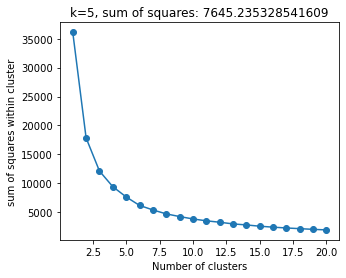

In [14]:
#Identify the number of clusters
s=[]
for i in range(1,21):
    kmeans = KMeans(i, random_state=42)
    kmeans.fit(pca_df)
    s.append(kmeans.inertia_)
# plot cluster scores
plt.figure(figsize=(5,4))
plt.plot(range(1,21),s,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('sum of squares within cluster')
plt.title(f'k=5, sum of squares: {s[4]}')
print('k=5 is ok')
plt.savefig(f'{work_dir}/output/figures/prediction_figures/pca/k_clusters.jpg',bbox_inches='tight',dpi=300)


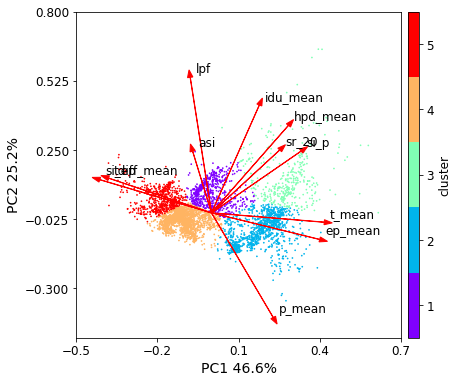

In [22]:
# run with k=5
kmeans = KMeans(5, random_state=42)
kmeans.fit(pca_df)
identified_clusters = kmeans.fit_predict(pca_df)
labels = kmeans.labels_

data_with_clusters = pca_df.copy()
data_with_clusters['Clusters'] = identified_clusters

xs = loadings[0]
ys = loadings[1]

cmap_vd2 = cm.get_cmap('rainbow', 5)
bounds = np.linspace(0,5,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
s=ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,c=data_with_clusters.Clusters,s=0.5,cmap=cmap_vd2,norm=norm)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='neither', pad=0.02,aspect=30, norm=norm)
cbar.set_ticks([0.5,1.5,2.5,3.5,4.5])
cbar.set_ticklabels(['1','2','3','4','5'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='cluster', size=12)
for i, varnames in enumerate(features):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features[i]]['xs'], # length of the arrow along x
        ld_df.loc[features[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features[i]]['xs']+0.02, ld_df.loc[features[i]]['ys']+0.02, varnames,size=12)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters_selected.jpg',bbox_inches='tight',dpi=300)


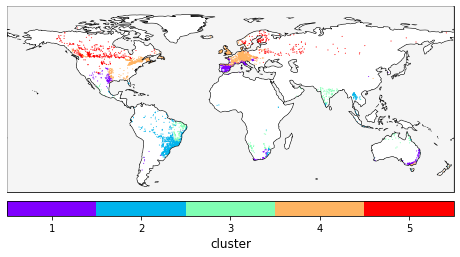

In [23]:
# map Sr
data_sources = 'gswp-p_gleam-ep_gswp-t'
co = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
co = co.dropna()
co['cluster'] = data_with_clusters['Clusters'].values
co.to_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv')

cmap_vd2 = cm.get_cmap('rainbow', 5)
bounds = np.linspace(0,5,6)
bounds2 = np.linspace(0,5,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(co.lon,co.lat,s=0.8,c=co['cluster'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.02,aspect=30, norm=norm)
cbar.set_ticks([0.5,1.5,2.5,3.5,4.5])
cbar.set_ticklabels(['1','2','3','4','5'])
cbar.set_label(label='cluster', size=12)
ax.set_title('',size=14)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/cluster_map.jpg', bbox_inches='tight',dpi=300)


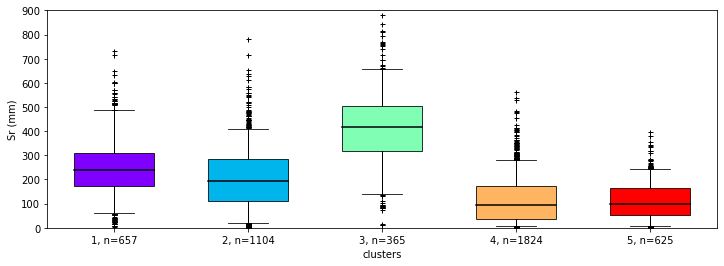

In [25]:
boxprops1 = dict(facecolor=cmap_vd2(0),color="black",linewidth=0.8)
boxprops2 = dict(facecolor=cmap_vd2(1),color="black",linewidth=0.8)
boxprops3 = dict(facecolor=cmap_vd2(2),color="black",linewidth=0.8)
boxprops4 = dict(facecolor=cmap_vd2(3),color="black",linewidth=0.8)
boxprops5 = dict(facecolor=cmap_vd2(4),color="black",linewidth=0.8)
medianprops = dict(color="black",linewidth=1.5)
flierprops = dict(color='black',marker='+',markersize=5)
capprops = dict(linestyle='-', linewidth=0.8, color='Black')

co1 = co[co.cluster==0]
co2 = co[co.cluster==1]
co3 = co[co.cluster==2]
co4 = co[co.cluster==3]
co5 = co[co.cluster==4]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.boxplot(co1.sr_20,positions=[1],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.boxplot(co2.sr_20,positions=[2],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.boxplot(co3.sr_20,positions=[3],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops3,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.boxplot(co4.sr_20,positions=[4],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops4,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.boxplot(co5.sr_20,positions=[5],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops5,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.xaxis.set_ticks([1,2,3,4,5])
ax.xaxis.set_ticklabels([f'1, n={len(co1)}',f'2, n={len(co2)}',f'3, n={len(co3)}',f'4, n={len(co4)}',f'5, n={len(co5)}'])
ax.set_ylabel('Sr (mm)')
ax.set_xlabel('clusters')
ax.set_ylim(0,900)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/cluster_sr_boxplot.jpg', bbox_inches='tight',dpi=300)


### pca landscape variables only using climate clusters

In [43]:
def pca_per_cluster(features,df,cl,col):
    lf = len(features)
    X = df[features]
    X = X.dropna()
    X = StandardScaler().fit_transform(X) #standardize all values
    X = pd.DataFrame(X,columns=features)

    pca = PCA(n_components=lf)
    components = pca.fit_transform(X)
    loadings = pca.components_ #eigenvector, length represents variance var explains

    # Create dataframe
    pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
    pca_df_scaled = pca_df.copy()
    scaler_df = pca_df[['PC1', 'PC2']]
    scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
    for index in scaler.index:
        pca_df_scaled[index] *= scaler[index]

    per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
    
    ld_df = pd.DataFrame(index=features, columns=['xs','ys'])
    ld_df['xs'] = loadings[0]
    ld_df['ys'] = loadings[1]
    ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)
    
    ld_sortx = abs(ld_df).sort_values('xs',ascending=False)
    ld_sortx = ld_sortx[0:20]
    ld_sortx = ld_sortx.rename(columns={'xs':f'xs_{cl}','ys':f'ys_{cl}'})
    ld_sortx['rank'] = np.arange(1,len(ld_sortx)+1,1)
    ld_sortx = ld_sortx.drop(columns=['len',f'ys_{cl}'])
    
    ld_sorty = abs(ld_df).sort_values(f'ys',ascending=False)
    ld_sorty = ld_sorty[0:20]
    ld_sorty = ld_sorty.rename(columns={'xs':f'xs_{cl}','ys':f'ys_{cl}'})
    ld_sorty['rank'] = np.arange(1,len(ld_sorty)+1,1)
    ld_sorty = ld_sorty.drop(columns=['len',f'xs_{cl}'])
    
    x,y = ld_sortx, ld_sorty
    x[f'varx_{cl}'] = x.index
    x = x.set_index('rank')
    y[f'vary_{cl}'] = y.index
    y = y.set_index('rank')
    xy = pd.concat([x,y],axis=1)
    # xy.to_csv(f'{work_dir}/output/regression/loadings_per_cluster_{cl}.csv')
    
    # split features for visualization of PCA
    p = int(np.round((lf/7),0))
    features1=features[0:p]
    features2=features[p:2*p]
    features3=features[2*p:3*p]
    features4=features[3*p:4*p]
    features5=features[4*p:5*p]
    features6=features[5*p:6*p]
    features7=features[6*p:]
    xs = loadings[0]
    ys = loadings[1]

    # make figure
    fig=plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    s=ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,color=col,s=0.5,cmap=cmap_vd2,norm=norm)
    for i, varnames in enumerate(features):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features[i]]['xs'], # length of the arrow along x
            ld_df.loc[features[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features[i]]['xs']+0.02, ld_df.loc[features[i]]['ys']+0.02, varnames,size=12)
    xticks = np.linspace(-0.5,0.7, num=5)
    yticks = np.linspace(-0.3,0.8, num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
    ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
    ax.set_title(f'Cluster {cl}',size=12)
#     fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters_cluster_{cl}.jpg',bbox_inches='tight',dpi=300)
    
    return xy

In [44]:
col1 = cmap_vd2(0)
col2 = cmap_vd2(1)
col3 = cmap_vd2(2)
col4 = cmap_vd2(3)
col5 = cmap_vd2(4)

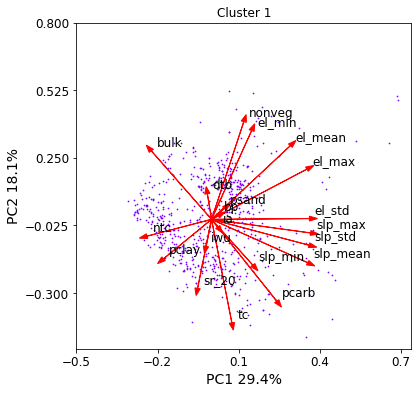

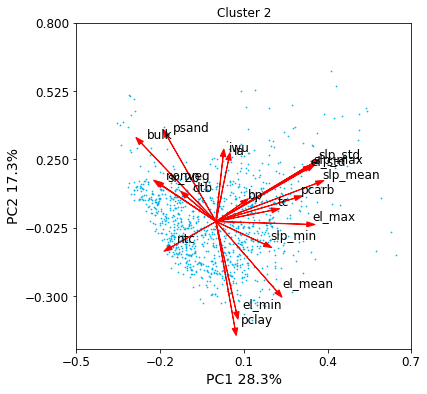

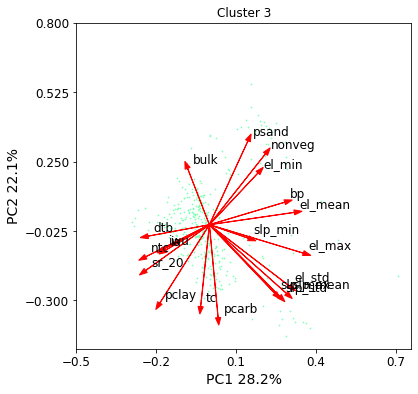

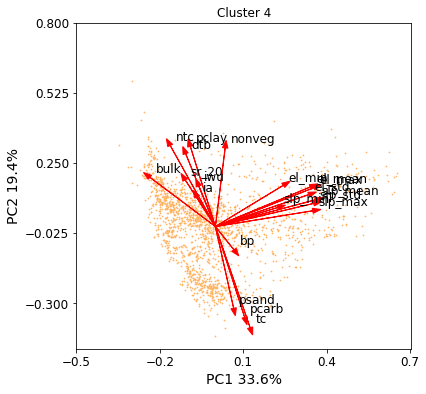

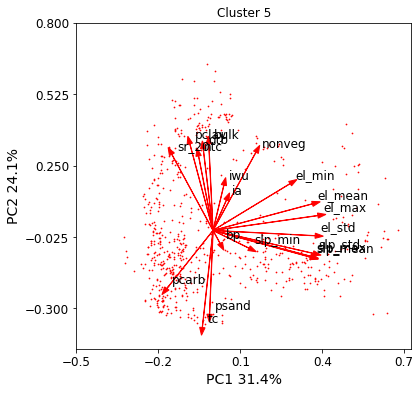

In [45]:
# separate analysis for cluster 5
features = ['tc', 'ntc', 'nonveg', 'el_mean', 'el_min',
   'el_max', 'el_std', 'slp_mean', 'slp_max', 'slp_min', 'slp_std', 'iwu',
   'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk', 'sr_20']

xy1 = pca_per_cluster(features,co1,'1',col1) 
xy2 = pca_per_cluster(features,co2,'2',col2) 
xy3 = pca_per_cluster(features,co3,'3',col3) 
xy4 = pca_per_cluster(features,co4,'4',col4) 
xy5 = pca_per_cluster(features,co5,'5',col5) 

/tmp/ipykernel_116/4145500112.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tc_group'][(df.tc<0.15)] = 0
/tmp/ipykernel_116/4145500112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tc_group'][(df.tc>0.15)&(df.tc<0.5)] = 1
/tmp/ipykernel_116/4145500112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tc_group'][(df.tc>0.5)] = 2


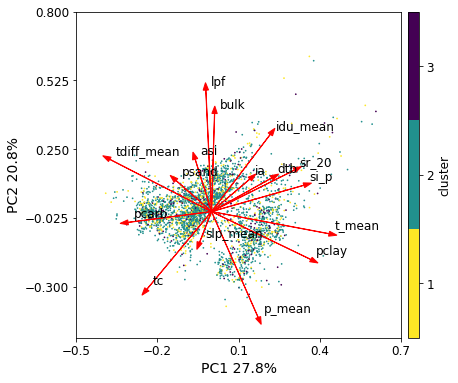

In [38]:
# color pca by tree cover group
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f)
df = df.dropna()
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l'])
df = df.drop(columns=['q_mean'])
df['tc_group'] = np.zeros(len(df))
df['tc_group'][(df.tc<0.15)] = 0
df['tc_group'][(df.tc>0.15)&(df.tc<0.5)] = 1
df['tc_group'][(df.tc>0.5)] = 2

data_with_clusters = pca_df.copy()
data_with_clusters['Clusters'] = df['tc_group']

xs = loadings[0]
ys = loadings[1]

cmap_vd2 = cm.get_cmap('viridis_r', 5)
bounds = np.linspace(0,3,4)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
s=ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,c=data_with_clusters.Clusters,s=0.5,cmap=cmap_vd2,norm=norm)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='neither', pad=0.02,aspect=30, norm=norm)
cbar.set_ticks([0.5,1.5,2.5])
cbar.set_ticklabels(['1','2','3'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='cluster', size=12)
for i, varnames in enumerate(features):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features[i]]['xs'], # length of the arrow along x
        ld_df.loc[features[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features[i]]['xs']+0.02, ld_df.loc[features[i]]['ys']+0.02, varnames,size=12)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters_selected_tc.jpg',bbox_inches='tight',dpi=300)

In [39]:
def plot_sr_vs_var_clusters(df,var1,var2,mode):
    cmap = cm.get_cmap('viridis_r', 5)
    bounds = np.linspace(0,5,6)
    bounds2 = np.linspace(0,5,6)
    norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

    fig = plt.figure(figsize=(20, 6))
    ax1 = plt.subplot(2,6,3)
    ax2 = plt.subplot(2,6,4)
    ax3 = plt.subplot(2,6,5)
    ax4 = plt.subplot(2,6,9)
    ax6 = plt.subplot(2,6,10)
    ax5 = plt.subplot(1,3,1)
    
    axes = [ax1, ax2, ax3, ax4,ax5]
    s = ax5.scatter(df[var1],df[var2],c=df['cluster'],s=0.5,cmap=cmap,norm=norm)
    cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='neither', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label='cluster', size=12)
    cbar.set_ticks([0.5,1.5,2.5,3.5,4.5])
    cbar.set_ticklabels(['1','2','3','4','5'])
    ax5.set_xlabel(var1,size=12)
    ax5.set_ylabel(var2,size=12)
    ax1.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax2.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax3.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax4.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax5.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax6.set_xlim(df[var1].quantile(0.01),df[var1].quantile(0.99))
    ax1.set_ylim(0,900)
    ax2.set_ylim(0,900)
    ax3.set_ylim(0,900)
    ax4.set_ylim(0,900)
    ax5.set_ylim(0,900)
    ax6.set_ylim(0,900)
    rs = np.corrcoef(df[var1],df[var2])[0,1]**2
    ax5.set_title(f'n={len(df[var1])}; r-squared: {np.round(rs,3)}')
    ax5.tick_params(labelsize=12)
    ax1.scatter(df[var1][df['cluster']==0],df[var2][df['cluster']==0],s=0.5,color=cmap(0),norm=norm)
    ax2.scatter(df[var1][df['cluster']==1],df[var2][df['cluster']==1],s=0.5,color=cmap(1),norm=norm)
    ax3.scatter(df[var1][df['cluster']==2],df[var2][df['cluster']==2],s=0.5,color=cmap(2),norm=norm)
    ax4.scatter(df[var1][df['cluster']==3],df[var2][df['cluster']==3],s=0.5,color=cmap(3),norm=norm)
    ax6.scatter(df[var1][df['cluster']==4],df[var2][df['cluster']==4],s=0.5,color=cmap(4),norm=norm)
    fig.savefig(f'{work_dir}/output/figures/prediction_figures/sr_scatters/{mode}/{var1}_{var2}.jpg', bbox_inches='tight',dpi=300)
    plt.close()
    

In [126]:
df=co
var = features
for i in var:
    plot_sr_vs_var_clusters(df,i,'sr_20','clusters5')

### separate pca for each cluster

In [16]:
def pca_per_cluster(features,df,cl,col):
    lf = len(features)
    X = df[features]
    X = X.dropna()
    X = StandardScaler().fit_transform(X) #standardize all values
    X = pd.DataFrame(X,columns=features)

    pca = PCA(n_components=lf)
    components = pca.fit_transform(X)
    loadings = pca.components_ #eigenvector, length represents variance var explains

    # Create dataframe
    pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
    pca_df_scaled = pca_df.copy()
    scaler_df = pca_df[['PC1', 'PC2']]
    scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
    for index in scaler.index:
        pca_df_scaled[index] *= scaler[index]

    per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
    
    ld_df = pd.DataFrame(index=features, columns=['xs','ys'])
    ld_df['xs'] = loadings[0]
    ld_df['ys'] = loadings[1]
    ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)
    
    ld_sortx = abs(ld_df).sort_values('xs',ascending=False)
    ld_sortx = ld_sortx[0:20]
    ld_sortx = ld_sortx.rename(columns={'xs':f'xs_{cl}','ys':f'ys_{cl}'})
    ld_sortx['rank'] = np.arange(1,len(ld_sortx)+1,1)
    ld_sortx = ld_sortx.drop(columns=['len',f'ys_{cl}'])
    
    ld_sorty = abs(ld_df).sort_values(f'ys',ascending=False)
    ld_sorty = ld_sorty[0:20]
    ld_sorty = ld_sorty.rename(columns={'xs':f'xs_{cl}','ys':f'ys_{cl}'})
    ld_sorty['rank'] = np.arange(1,len(ld_sorty)+1,1)
    ld_sorty = ld_sorty.drop(columns=['len',f'xs_{cl}'])
    
    x,y = ld_sortx, ld_sorty
    x[f'varx_{cl}'] = x.index
    x = x.set_index('rank')
    y[f'vary_{cl}'] = y.index
    y = y.set_index('rank')
    xy = pd.concat([x,y],axis=1)
    # xy.to_csv(f'{work_dir}/output/regression/loadings_per_cluster_{cl}.csv')
    
    # split features for visualization of PCA
    p = int(np.round((lf/7),0))
    features1=features[0:p]
    features2=features[p:2*p]
    features3=features[2*p:3*p]
    features4=features[3*p:4*p]
    features5=features[4*p:5*p]
    features6=features[5*p:6*p]
    features7=features[6*p:]
    xs = loadings[0]
    ys = loadings[1]

    # make figure
    fig=plt.figure(figsize=(22,12))
    ax = fig.add_subplot(241)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)

    for i, varnames in enumerate(features):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features[i]]['xs'], # length of the arrow along x
            ld_df.loc[features[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
    ax.set_title(f'Cluster {cl}',size=12)

    ax = fig.add_subplot(242)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features1):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features1[i]]['xs'], # length of the arrow along x
            ld_df.loc[features1[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features1[i]]['xs']+0.02, ld_df.loc[features1[i]]['ys']+0.02, varnames,size=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(features1,size=9)

    ax = fig.add_subplot(243)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features2):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features2[i]]['xs'], # length of the arrow along x
            ld_df.loc[features2[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features2[i]]['xs']+0.02, ld_df.loc[features2[i]]['ys']+0.02, varnames,size=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(features2,size=9)

    ax = fig.add_subplot(244)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features3):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features3[i]]['xs'], # length of the arrow along x
            ld_df.loc[features3[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features3[i]]['xs']+0.02, ld_df.loc[features3[i]]['ys']+0.02, varnames,size=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(features3,size=11)

    ax = fig.add_subplot(245)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features4):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features4[i]]['xs'], # length of the arrow along x
            ld_df.loc[features4[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features4[i]]['xs']+0.02, ld_df.loc[features4[i]]['ys']+0.02, varnames,size=10)
    ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
    ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
    ax.set_title(features4,size=11)

    ax = fig.add_subplot(246)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features5):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features5[i]]['xs'], # length of the arrow along x
            ld_df.loc[features5[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features5[i]]['xs']+0.02, ld_df.loc[features5[i]]['ys']+0.02, varnames,size=10) 
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
    ax.set_title(features5,size=9)

    ax = fig.add_subplot(247)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features6):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features6[i]]['xs'], # length of the arrow along x
            ld_df.loc[features6[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features6[i]]['xs']+0.02, ld_df.loc[features6[i]]['ys']+0.02, varnames,size=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
    ax.set_title(features6,size=9)

    ax = fig.add_subplot(248)
    ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,color=col)
    for i, varnames in enumerate(features7):
        ax.arrow(
            0, 0, # coordinates of arrow base
            ld_df.loc[features7[i]]['xs'], # length of the arrow along x
            ld_df.loc[features7[i]]['ys'], # length of the arrow along y
            color='r',
            head_width=0.02
            )
        ax.text(ld_df.loc[features7[i]]['xs']+0.02, ld_df.loc[features7[i]]['ys']+0.02, varnames,size=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
    ax.set_title(features7,size=11)
    fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters_cluster_{cl}.jpg',bbox_inches='tight',dpi=300)
    
    return xy

In [112]:
col1 = cmap_vd2(0)
col2 = cmap_vd2(1)
col3 = cmap_vd2(2)
col4 = cmap_vd2(3)
col5 = cmap_vd2(4)

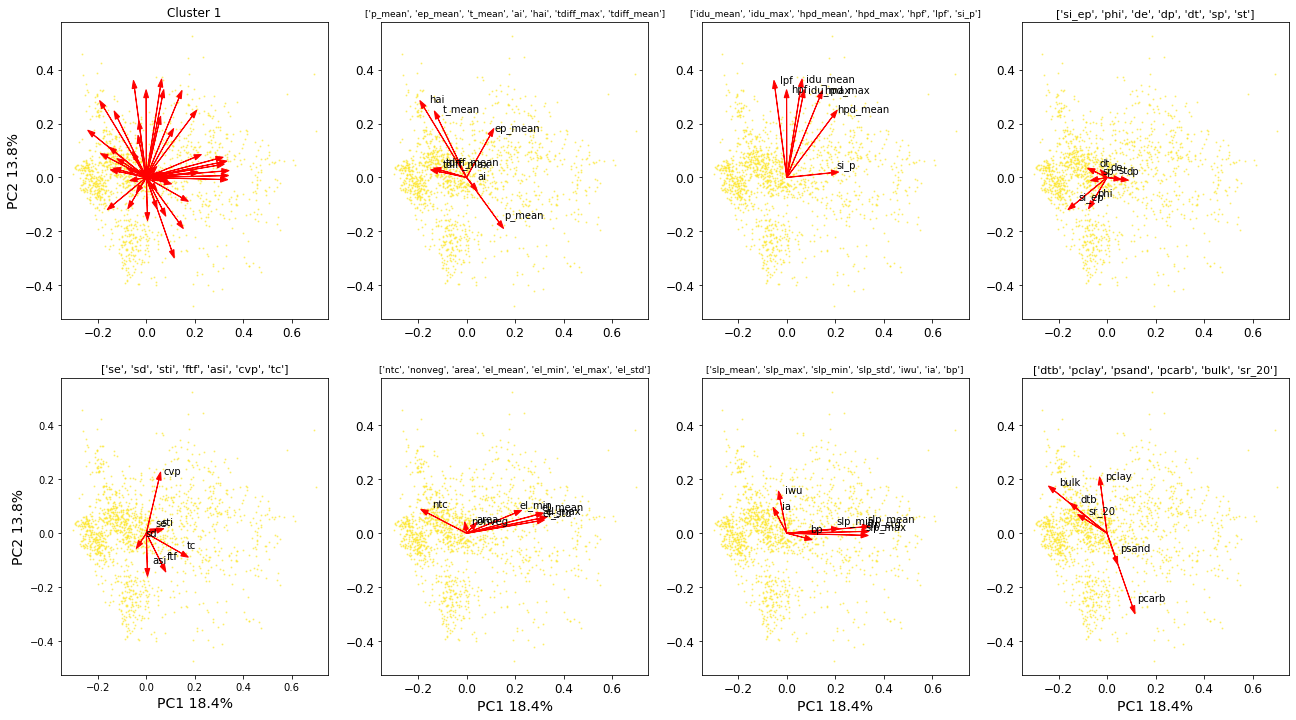

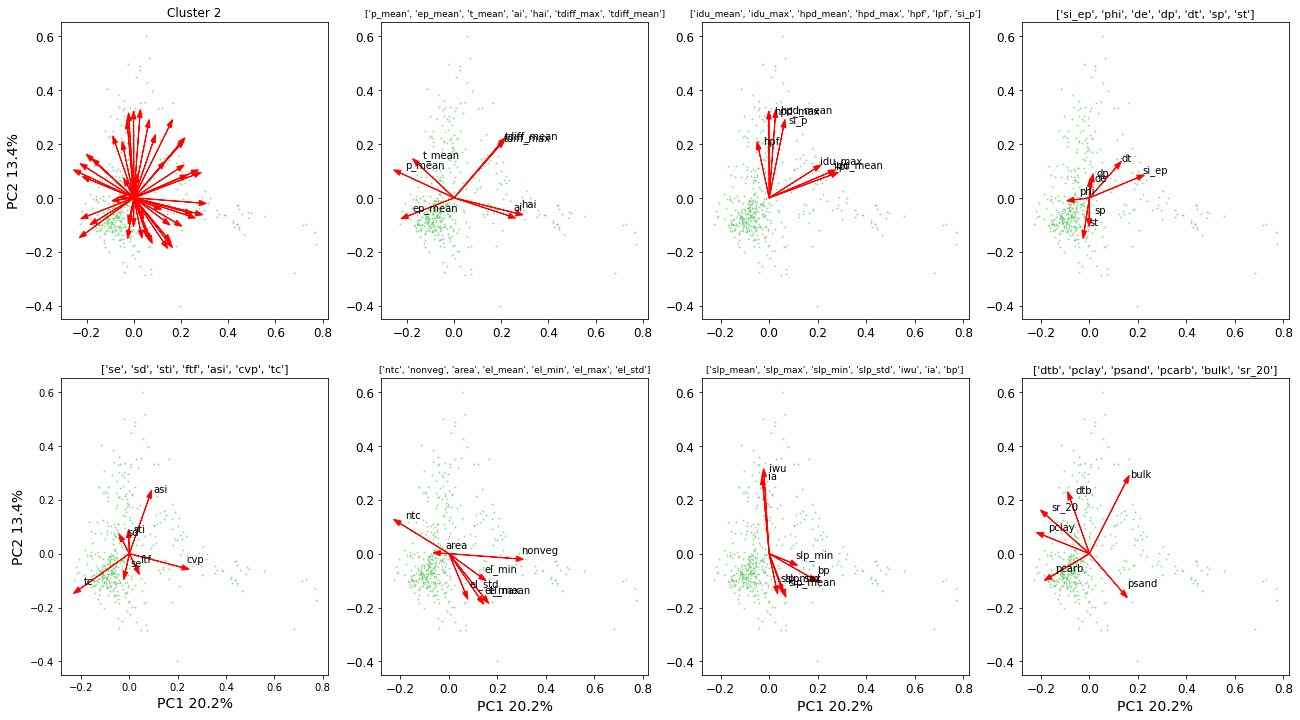

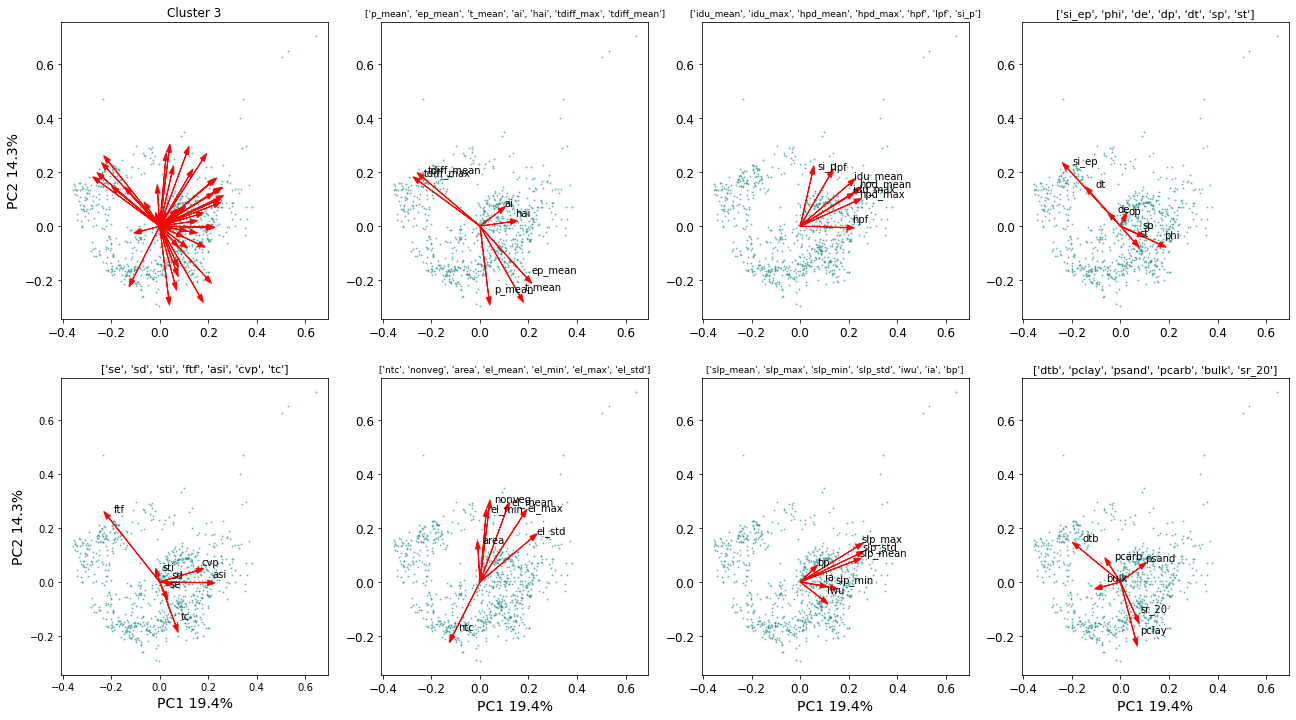

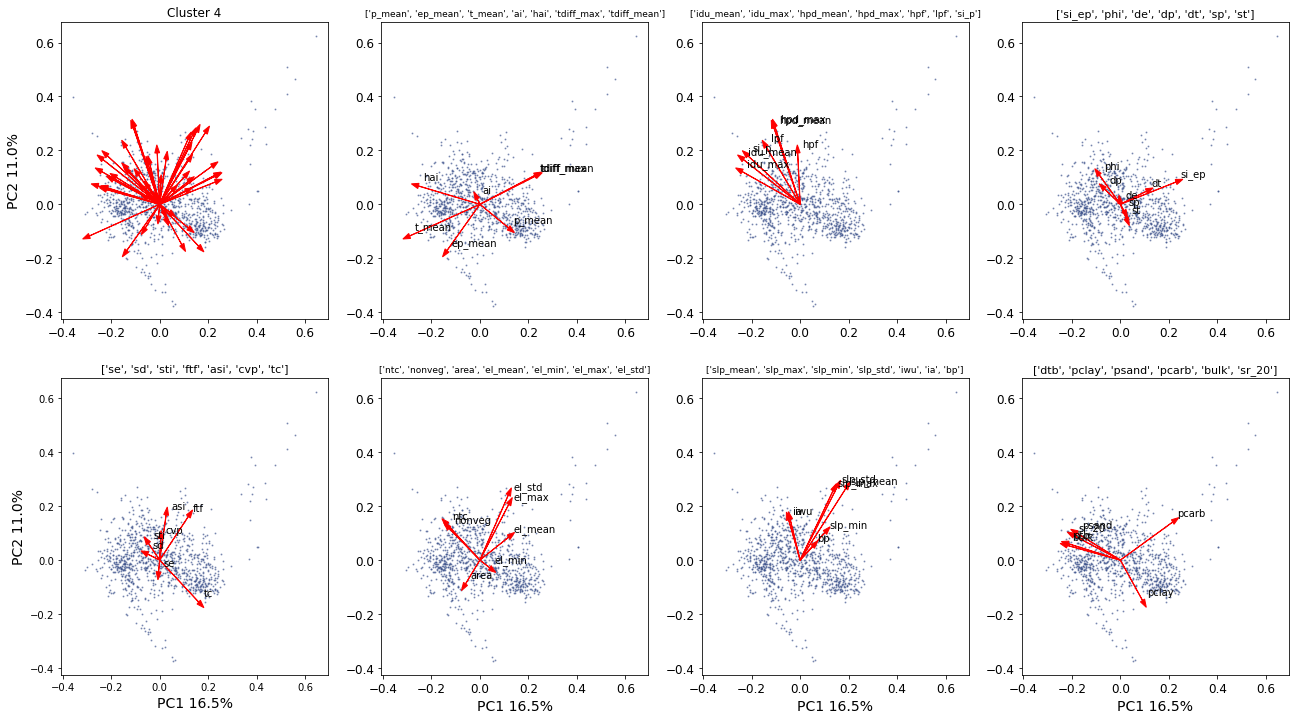

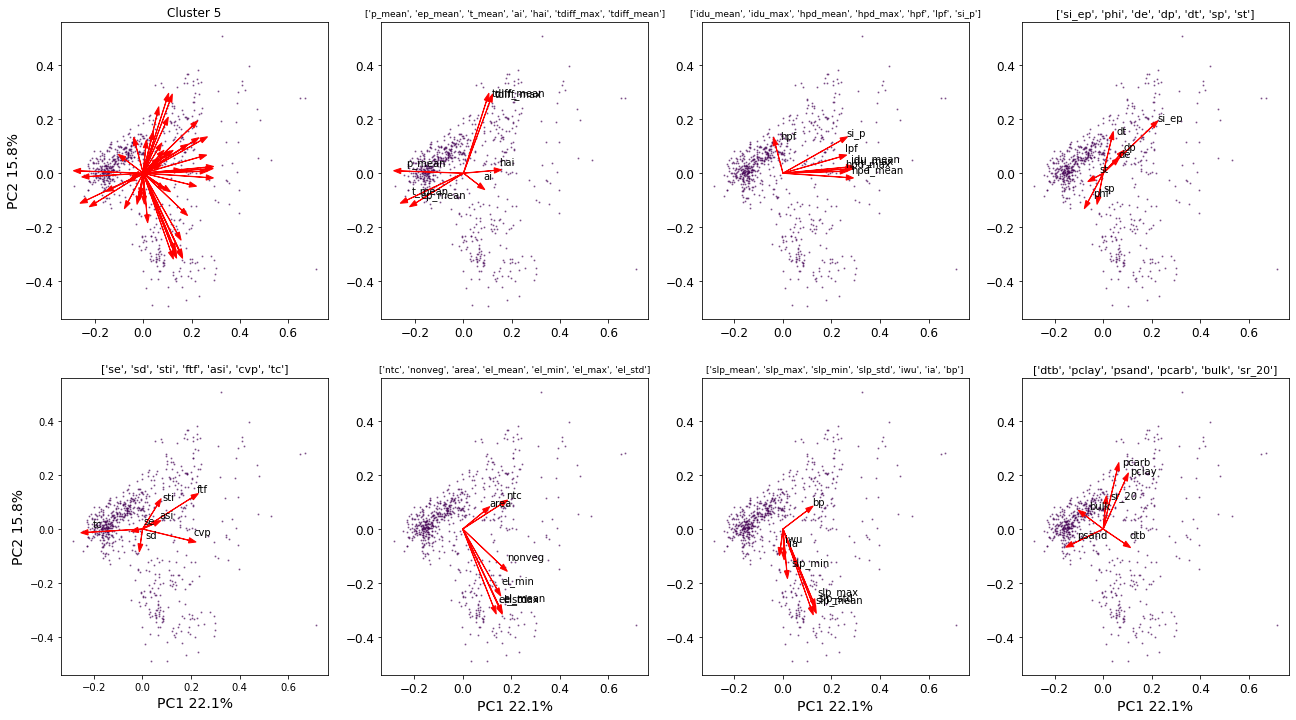

In [113]:
# separate analysis for cluster 5
features = ['p_mean', 'ep_mean', 't_mean', 'ai', 'hai', 'tdiff_max', 'tdiff_mean',
   'idu_mean', 'idu_max', 'hpd_mean', 'hpd_max', 'hpf', 'lpf', 'si_p',
   'si_ep', 'phi', 'de', 'dp', 'dt', 'sp', 'st', 'se', 'sd', 'sti', 'ftf',
   'asi', 'cvp', 'tc', 'ntc', 'nonveg', 'area', 'el_mean', 'el_min',
   'el_max', 'el_std', 'slp_mean', 'slp_max', 'slp_min', 'slp_std', 'iwu',
   'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk', 'sr_20']

xy1 = pca_per_cluster(features,co1,'1',col1) 
xy2 = pca_per_cluster(features,co2,'2',col2) 
xy3 = pca_per_cluster(features,co3,'3',col3) 
xy4 = pca_per_cluster(features,co4,'4',col4) 
xy5 = pca_per_cluster(features,co5,'5',col5) 

In [115]:
c = pd.concat([xy1,xy2,xy3,xy4,xy5],axis=1)
c = np.round(c,2)
c.to_csv(f'{work_dir}/output/regression/loadings_per_cluster.csv')
c

xs_1     varx_1  ys_1    vary_1  xs_2      varx_2  ys_2      vary_2  \
rank                                                                        
1     0.31   slp_mean  0.34  idu_mean  0.28      nonveg  0.30    hpd_mean   
2     0.31    slp_std  0.33       lpf  0.26         hai  0.29     hpd_max   
3     0.31    slp_max  0.30   idu_max  0.26         lpf  0.29         iwu   
4     0.30     el_max  0.30       hpf  0.25    idu_mean  0.26        bulk   
5     0.29     el_std  0.30   hpd_max  0.23          ai  0.26        si_p   
6     0.29    el_mean  0.27     pcarb  0.23      p_mean  0.26          ia   
7     0.22       bulk  0.26       hai  0.22         cvp  0.21         asi   
8     0.20     el_min  0.23  hpd_mean  0.21          tc  0.20         dtb   
9     0.19   hpd_mean  0.22    t_mean  0.20         ntc  0.20  tdiff_mean   
10    0.18    slp_min  0.20       cvp  0.20       si_ep  0.19   tdiff_max   
11    0.18       si_p  0.18     pclay  0.20     ep_mean  0.18         hpf   
12    0.18        hai  0.17    p_mean  0.20  tdiff_mean  0.16      el_max   
13    0.16        ntc  0.16      bulk  0.19   tdiff_max  0.16     el_mean   
14    0.15         tc  0.16   ep_mean  0.19       pclay  0.14       sr_20   
15    0.14      si_ep  0.13       asi  0.19     idu_max  0.14      el_std   
16    0.13    hpd_max  0.13       iwu  0.18       sr_20  0.14       psand   
17    0.13     p_mean  0.12       ftf  0.18          bp  0.13    slp_mean   
18    0.13        dtb  0.10     si_ep  0.16       pcarb  0.13          tc   
19    0.12  tdiff_max  0.09       dtb  0.15      t_mean  0.13      t_mean   
20    0.12     t_mean  0.09       phi  0.15        bulk  0.12          st   

      xs_3      varx_3  ys_3      vary_3  xs_4      varx_4  ys_4    vary_4  \
rank                                                                         
1     0.25   tdiff_max  0.27      nonveg  0.29      t_mean  0.29   hpd_max   
2     0.24  tdiff_mean  0.27     el_mean  0.25         hai  0.28  hpd_mean   
3     0.24     slp_std  0.26      p_mean  0.24     idu_max  0.27   slp_std   
4     0.23     slp_max  0.26      t_mean  0.23    idu_mean  0.27  slp_mean   
5     0.22     hpd_max  0.25      el_max  0.23  tdiff_mean  0.26   slp_max   
6     0.22    hpd_mean  0.24      el_min  0.23       si_ep  0.24    el_std   
7     0.22    slp_mean  0.24         ftf  0.23   tdiff_max  0.21       lpf   
8     0.22       si_ep  0.21       si_ep  0.22        bulk  0.21    el_max   
9     0.21      el_std  0.21       pclay  0.22       pcarb  0.19       hpf   
10    0.21         ftf  0.20         ntc  0.22        si_p  0.18      si_p   
11    0.20    idu_mean  0.19        si_p  0.21         dtb  0.17   ep_mean   
12    0.20     idu_max  0.19     ep_mean  0.19       sr_20  0.17       asi   
13    0.20         asi  0.19         lpf  0.19    slp_mean  0.17  idu_mean   
14    0.19         hpf  0.18  tdiff_mean  0.18       psand  0.16       ftf   
15    0.19     ep_mean  0.17   tdiff_max  0.16          tc  0.16        tc   
16    0.18      el_max  0.16      el_std  0.15     slp_std  0.15       iwu   
17    0.17         dtb  0.16          tc  0.14         lpf  0.15     pclay   
18    0.16      t_mean  0.16    idu_mean  0.14     slp_max  0.15        ia   
19    0.16         phi  0.13     slp_max  0.14     ep_mean  0.14     pcarb   
20    0.15         cvp  0.13         dtb  0.14         ntc  0.13       ntc   

      xs_5    varx_5  ys_5      vary_5  
rank                                    
1     0.26  idu_mean  0.29    slp_mean  
2     0.26  hpd_mean  0.29      el_max  
3     0.26   idu_max  0.29      el_std  
4     0.26    p_mean  0.29     slp_std  
5     0.24      si_p  0.28     el_mean  
6     0.24   hpd_max  0.27  tdiff_mean  
7     0.23    t_mean  0.27   tdiff_max  
8     0.23       lpf  0.26     slp_max  
9     0.22        tc  0.22      el_min  
10    0.20       ftf  0.22       pcarb  
11    0.20     si_ep  0.18       pclay  
12    0.20   ep_mean  0.18       si_ep  
13    0.19       cvp

### PCA per tc group

In [20]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.dropna()
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l'])
df = df.drop(columns=['q_mean'])
df['tc_group'] = np.zeros(len(df))
df['tc_group'][(df.tc<0.15)] = 0
df['tc_group'][(df.tc>0.15)&(df.tc<0.5)] = 1
df['tc_group'][(df.tc>0.5)] = 2
co1 = df[df['tc_group']==0]
co2 = df[df['tc_group']==1]
co3 = df[df['tc_group']==2]

cmap_vd2 = cm.get_cmap('viridis_r', 3)
col1 = cmap_vd2(0)
col2 = cmap_vd2(1)
col3 = cmap_vd2(2)

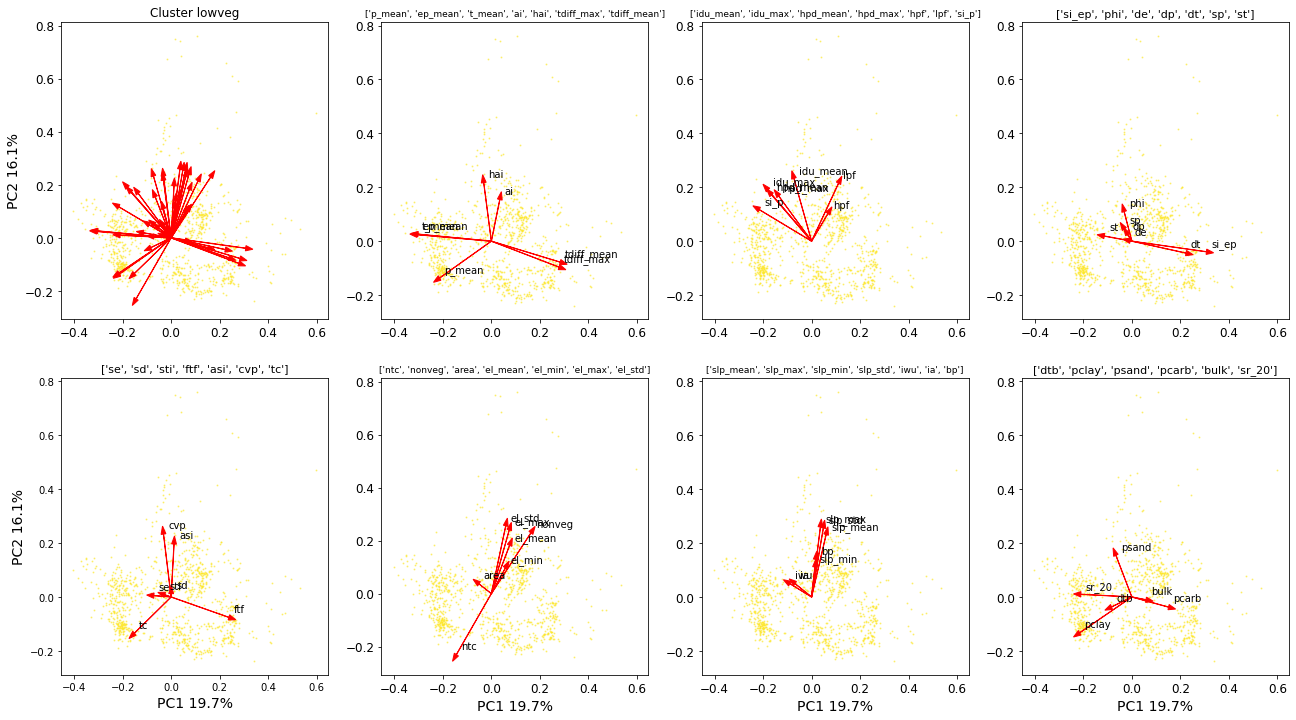

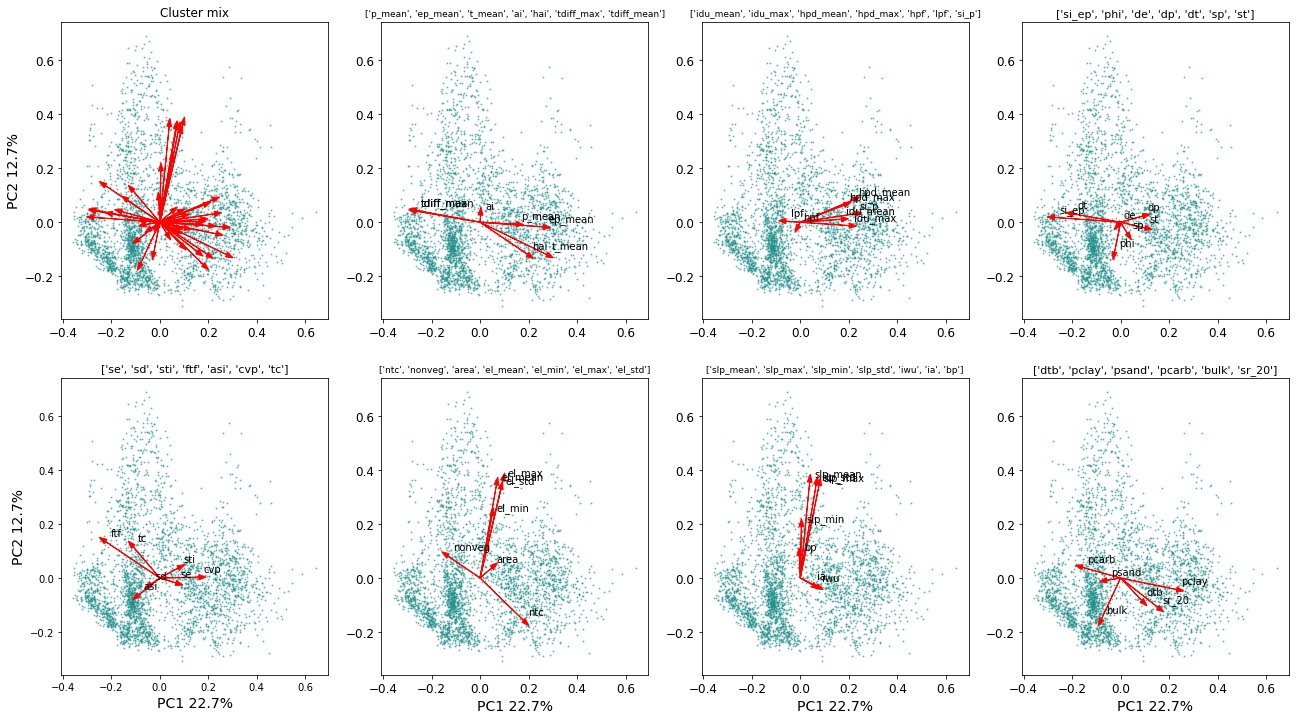

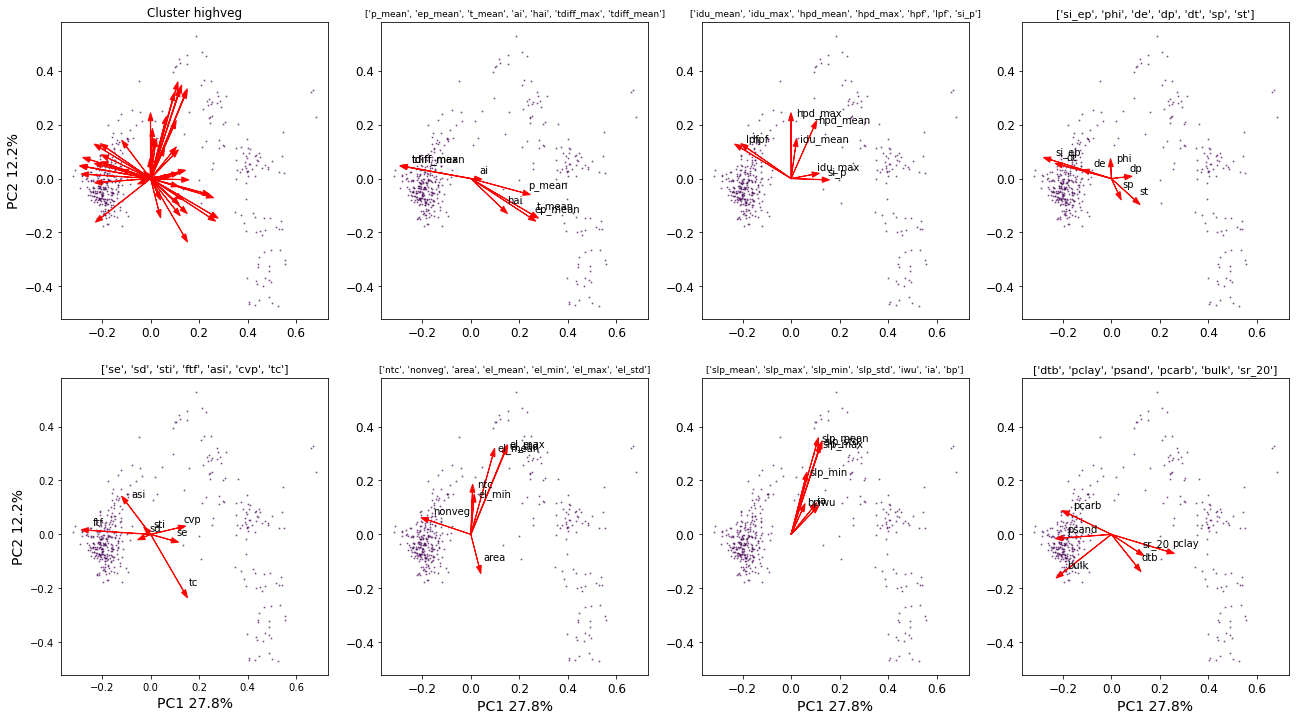

In [21]:
# separate analysis for cluster 5
features = ['p_mean', 'ep_mean', 't_mean', 'ai', 'hai', 'tdiff_max', 'tdiff_mean',
   'idu_mean', 'idu_max', 'hpd_mean', 'hpd_max', 'hpf', 'lpf', 'si_p',
   'si_ep', 'phi', 'de', 'dp', 'dt', 'sp', 'st', 'se', 'sd', 'sti', 'ftf',
   'asi', 'cvp', 'tc', 'ntc', 'nonveg', 'area', 'el_mean', 'el_min',
   'el_max', 'el_std', 'slp_mean', 'slp_max', 'slp_min', 'slp_std', 'iwu',
   'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk', 'sr_20']

xy1 = pca_per_cluster(features,co1,'lowveg',col1) 
xy2 = pca_per_cluster(features,co2,'mix',col2) 
xy3 = pca_per_cluster(features,co3,'highveg',col3) 


In [23]:
c = pd.concat([xy1,xy2,xy3],axis=1)
c = np.round(c,2)
c.to_csv(f'{work_dir}/output/regression/loadings_per_tcgroup.csv')
c

xs_lowveg varx_lowveg  ys_lowveg vary_lowveg  xs_mix    varx_mix  \
rank                                                                     
1          0.31       si_ep       0.26     slp_max    0.27      t_mean   
2          0.31      t_mean       0.26     slp_std    0.27       si_ep   
3          0.30     ep_mean       0.26      el_std    0.26   tdiff_max   
4          0.28  tdiff_mean       0.24      el_max    0.26  tdiff_mean   
5          0.28   tdiff_max       0.23         cvp    0.26     ep_mean   
6          0.24         ftf       0.23    idu_mean    0.23       pclay   
7          0.22          dt       0.23    slp_mean    0.23        si_p   
8          0.22        si_p       0.23         ntc    0.22         ftf   
9          0.21       pclay       0.23      nonveg    0.22    hpd_mean   
10         0.21      p_mean       0.22         hai    0.20     idu_max   
11         0.21       sr_20       0.21         lpf    0.20          dt   
12         0.18     idu_max       0.20         asi    0.20         hai   
13         0.17    hpd_mean       0.19     idu_max    0.18     hpd_max   
14         0.16      nonveg       0.18     el_mean    0.18         ntc   
15         0.15          tc       0.17    hpd_mean    0.17    idu_mean   
16         0.15       pcarb       0.17     hpd_max    0.16         cvp   
17         0.14         ntc       0.15       psand    0.16       pcarb   
18         0.14     hpd_max       0.15          ai    0.15       sr_20   
19         0.11          st       0.14          bp    0.15      p_mean   
20         0.11         lpf       0.14      p_mean    0.13      nonveg   

      ys_mix  vary_mix  xs_highveg varx_highveg  ys_highveg vary_highveg  
rank                                                                      
1       0.36    el_max        0.26   tdiff_mean        0.33     slp_mean  
2       0.36  slp_mean        0.26    tdiff_max        0.32      slp_std  
3       0.35   slp_std        0.26          ftf        0.31      slp_max  
4       0.35   el_mean        0.25       t_mean        0.31       el_max  
5       0.34   slp_max        0.25        si_ep        0.30       el_std  
6       0.33    el_std        0.24      ep_mean        0.29      el_mean  
7       0.23    el_min        0.23        pclay        0.21      hpd_max  
8       0.19   slp_min        0.22       p_mean        0.21           tc  
9       0.16       ntc        0.21          lpf        0.20      slp_min  
10      0.15      bulk        0.20         bulk        0.19     hpd_mean  
11      0.14       ftf        0.20           dt        0.16          ntc  
12      0.12    t_mean        0.20        psand        0.14         bulk  
13      0.12       hai        0.18          hpf        0.14      ep_mean  
14      0.12        tc        0.18       nonveg        0.13       t_mean  
15      0.11       phi        0.18        pcarb        0.12       el_min  
16      0.11     sr_20        0.14       el_max        0.12     idu_mean  
17      0.08  hpd_mean        0.14       el_std        0.12          asi  
18      0.08       dtb        0.14           tc        0.12         area  
19      0.08        bp        0.13          hai        0.12          dtb  
20      0.08    nonveg        0.13         si_p        0.11          hpf

## 4. Multi Linear Regression

In [46]:
# performance metrics
def rmse(y,y_pred):
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

def r2_adj(y,y_pred,features):
    r2 = r2_score(y, y_pred)
    r2_adj = 1-(((1-r2)*(len(y)-1))/(len(y)-len(features)-1))
    return r2_adj

def llf_(y, X, pr):
    # return maximized log likelihood
    nobs = float(X.shape[0])
    nobs2 = nobs / 2.0
    nobs = float(nobs)
    resid = y - pr
    ssr = np.sum((resid)**2)
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
    return llf

def aic(y, X, pr, p):
    # return aic metric
    llf = llf_(y, X, pr)
    return -2*llf+2*p

In [47]:
def lin_regress(features,df,plot,cross_val):
    sr_rp = 'sr_20'
    dfx = df[features].values
    dfy = df[sr_rp].values
    X = dfx
    y = dfy.reshape(-1, 1)

    if (cross_val==True):
        kcv = 5
        regr = linear_model.LinearRegression()
        kf = KFold(n_splits=kcv, shuffle=True, random_state=42)
        train_mse_scores = []
        train_mae_scores = []
        train_rmse_scores = []
        train_r2_scores = []
        train_r2_adj_scores = []
        train_aic_scores = []
        test_mse_scores = []
        test_mae_scores = []
        test_rmse_scores = []
        test_r2_scores = []
        test_r2_adj_scores = []
        test_aic_scores = []
        coef_values = []
        for train_index, test_index in kf.split(X):
            # print('trainlen',len(train_index), 'testlen',len(test_index))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            scalery = StandardScaler().fit(y_train)
            scalerx = StandardScaler().fit(X_train)
            X_train, y_train = scalerx.transform(X_train),scalery.transform(y_train)
            X_test, y_test = scalerx.transform(X_test),scalery.transform(y_test)
            regr.fit(X_train, y_train)
            test_y_pred = regr.predict(X_test)
            train_y_pred = regr.predict(X_train)

            y_train = scalery.inverse_transform(y_train)
            y_test = scalery.inverse_transform(y_test)
            train_y_pred = scalery.inverse_transform(train_y_pred)
            test_y_pred = scalery.inverse_transform(test_y_pred)

            train_mse = int(mean_squared_error(y_train, train_y_pred))
            train_mae = int(mean_absolute_error(y_train, train_y_pred))
            train_r2 = np.round(r2_score(y_train, train_y_pred),2)
            train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
            train_rmse = int(rmse(y_train,train_y_pred))
            train_aic = int(aic(y=y_train,X=X_train,pr=train_y_pred,p=len(features)+1))

            test_mse = int(mean_squared_error(y_test, test_y_pred))
            test_mae = int(mean_absolute_error(y_test, test_y_pred))
            test_r2 = np.round(r2_score(y_test, test_y_pred),2)
            test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
            test_rmse = int(rmse(y_test,test_y_pred))
            test_aic = int(aic(y=y_test,X=X_test,pr=test_y_pred,p=len(features)+1))

            train_mse_scores.append(train_mse)
            train_mae_scores.append(train_mae)
            train_rmse_scores.append(train_rmse)
            train_r2_scores.append(train_r2)
            train_r2_adj_scores.append(train_r2_adj)
            train_aic_scores.append(train_aic)
            test_mse_scores.append(test_mse)
            test_mae_scores.append(test_mae)
            test_rmse_scores.append(test_rmse)
            test_r2_scores.append(test_r2)
            test_r2_adj_scores.append(test_r2_adj)
            test_aic_scores.append(test_aic)
            coef_values.append(regr.coef_)

        train_mse = np.median(train_mse_scores)
        train_mae = np.median(train_mae_scores)
        train_rmse = np.median(train_rmse_scores)
        train_r2 = np.median(train_r2_scores)
        train_r2_adj = np.median(train_r2_adj_scores)
        test_mse = np.median(test_mse_scores)
        test_mae = np.median(test_mae_scores)
        test_rmse = np.median(test_rmse_scores)
        test_r2 = np.median(test_r2_scores)
        test_r2_adj = np.median(test_r2_adj_scores)
        coef = np.median(coef_values,axis=0)

        n_test = len(y_test)
        n_train = len(y_train)

    else:
        kcv = 'None'
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        scalery = StandardScaler().fit(y_train)
        scalerx = StandardScaler().fit(X_train)
        X_train, y_train = scalerx.transform(X_train),scalery.transform(y_train)
        X_test, y_test = scalerx.transform(X_test),scalery.transform(y_test)
        regr = linear_model.LinearRegression()
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        train_y_pred = regr.predict(X_train)
        test_y_pred = regr.predict(X_test)

        # The coefficients
        coef = regr.coef_

        # inverse scaler -> go back to [mm]
        y_train = scalery.inverse_transform(y_train)
        y_test = scalery.inverse_transform(y_test)
        train_y_pred = scalery.inverse_transform(train_y_pred)
        test_y_pred = scalery.inverse_transform(test_y_pred)

        # scores
        train_mse = int(mean_squared_error(y_train, train_y_pred))
        train_mae = int(mean_absolute_error(y_train, train_y_pred))
        train_r2 = np.round(r2_score(y_train, train_y_pred),2)
        train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
        train_rmse = int(rmse(y_train,train_y_pred))
        train_aic = int(aic(y=y_train,X=X_train,pr=train_y_pred,p=len(features)+1))

        test_mse = int(mean_squared_error(y_test, test_y_pred))
        test_mae = int(mean_absolute_error(y_test, test_y_pred))
        test_r2 = np.round(r2_score(y_test, test_y_pred),2)
        test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
        test_rmse = int(rmse(y_test,test_y_pred))
        test_aic = int(aic(y=y_test,X=X_test,pr=test_y_pred,p=len(features)+1))

        n_test = len(y_test)
        n_train = len(y_train)

    # add outcomes to dataframes
    cdf = pd.DataFrame(index=[0],columns=features[0:-1])
    cdf[features] = coef
    sdf = pd.DataFrame(index=[0])
    sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_aic']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_aic]
    sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_aic']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_aic]
    sdf[['n_train','n_test','kfold_cv']] = [n_train,n_test,kcv]
    tdf = pd.concat([cdf,sdf],axis=1)
    tdf = tdf.round(3)

    if (plot==True):
        fig = plt.figure(figsize=(9,4))
        ax = fig.add_subplot(121)
        x,y = y_train2,train_y_pred2
        ax.scatter(x, y, s=1)
        ax.plot([0,900],[0,900],'r--')
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')
        ax.set_title(f'C{i}, Train, n={len(y_train)}, R2-adj={np.round(train_r2_adj,2)}')
        ax.text(200,-270,f'{features}',size=11)
        ax.text(200,-350,f'{np.round(coef[0],3)}',size=11)
        ax = fig.add_subplot(122)
        x,y = y_test2,test_y_pred2
        ax.scatter(x, y, s=1)
        ax.plot([0,900],[0,900],'r--')
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_title(f'C{i}, Test, n={len(y_test)}, R2-adj={np.round(test_r2_adj,2)}')
    return tdf


In [48]:
import itertools
def get_combinations(lst): # creating a user-defined method
    combination = [] # empty list 
    for r in range(1, len(lst) + 1):
        # to generate combination
        combination.extend(itertools.combinations(lst, r))
    return combination

In [49]:
def run_combi_parallel(
    features_list=list,
    count_list=list,
    # threads=None
    threads=100
    ):
    # Set number of threads (cores) used for parallel run and map threads
    if threads is None:
        pool = Pool()
    else:
        pool = Pool(nodes=threads)
    # Run parallel models
    results = pool.map(
        combi_run,
        features_list,
        count_list
    )

In [50]:
def combi_run(features,count):
    df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
    df = df.dropna()
    df = df[df['sr_20']>0]
    dfc = df
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    features = np.asarray(features)
    l = lin_regress(features,dfc,plot=False,cross_val=False)
    l.index = [0]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    l.to_csv(f'{work_dir}/output/regression/test/{count}.csv') # maybe write to local directory to make it faster? or inside ubuntu directory ? 
    # l.to_csv(f'/home/fvanoorschot/test/{count}.csv')

### regression per cluster landscape variables

In [90]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
# features = ['tc', 'ntc', 'nonveg', 'el_mean', 'el_min',
#    'el_max', 'el_std', 'slp_mean', 'slp_max', 'slp_min', 'slp_std', 'iwu',
#    'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk']
features = ['tc', 'el_mean','slp_mean', 'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk']
ll = []
df = df[df['sr_20']>0]
clusters = [0,1,2,3,4]
m = []
for i in clusters:
    dfc = df[df.cluster==i]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = lin_regress(features,dfc,plot=False,cross_val=False)
    l.index = [i]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)

mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
dd = pd.DataFrame(index=md.index)
dd[features] = md[features]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = md[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd.to_csv(f'{work_dir}/output/regression/cl_clusters/clusters_regression_table_allvar.csv')

In [91]:
dd

tc  el_mean  slp_mean     ia     bp    dtb  pclay  psand  pcarb   bulk  \
0  0.255   -0.278     0.103  0.018  0.013  0.167  0.090 -0.154  0.153  0.115   
1 -0.213   -0.116    -0.101 -0.026 -0.015  0.304 -0.088 -0.019  0.029  0.119   
2  0.391   -0.175    -0.139 -0.104 -0.194  0.002  0.035 -0.072  0.035  0.201   
3 -0.225   -0.120    -0.040  0.020  0.029  0.129 -0.004 -0.021 -0.200 -0.153   
4  0.045   -0.357    -0.114  0.091 -0.028  0.136  0.309  0.018 -0.368  0.218   

   ...  train_aic  test_mse  test_rmse  test_mae  test_r2  test_r2_adj  \
0  ...       4833     11409        106        81     0.23         0.20   
1  ...       8044     11108        105        76     0.28         0.26   
2  ...       2771     10482        102        83     0.48         0.45   
3  ...      12774      6387         79        60     0.20         0.19   
4  ...       4011      3071         55        41     0.52         0.50   

   test_aic  n_train  n_test  kfold_cv  
0      3225      394     263      None  
1      5393      662     442      None  
2      1787      219     146      None  
3      8489     1094     730      None  
4      2738      375     250      None  

[5 rows x 25 columns]

### all combinations

In [92]:
# iterate over feature-combinations and over 5 clusters
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['tc', 'el_mean','slp_mean', 'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk']
all_combinations = get_combinations(features) # method call
ll = []
for j in all_combinations:
    df = df[df['sr_20']>0]
    clusters = [0,1,2,3,4]
    features = list(j)
    m = []
    for i in clusters:
        dfc = df[df.cluster==i]
        dfc_tc = np.round(dfc.tc.mean(),2)
        dfc_ntc = np.round(dfc.ntc.mean(),2)
        dfc_nonveg = np.round(dfc.nonveg.mean(),2)
        dfc_srm = int(dfc.sr_20.mean())
        dfc_srs = int(dfc.sr_20.std())
        l = lin_regress(features,dfc,plot=False,cross_val=False)
        if (l['test_r2_adj'].values[0]>0.1):
            l.index = [i]
            l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
            l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
            m.append(l)
    if (len(m)>0):
        mm = pd.concat(m)
        ll.append(mm)
md = pd.concat(ll)

In [93]:
# select for each cluster the 5 feature combinations with the largest r2-adj and plot output
l = []
clusters = [0,1,2,3,4]
for i in clusters:
    mdi = md.loc[i]
    mds = mdi.sort_values('test_r2_adj',ascending=False)[0:10]
    l.append(mds)
    mdsf = mds[features]
    for j in range(len(mds)):
        ft = mdsf.iloc[j].dropna().index.values
        dfc = df[df.cluster==i]
        lin_regress(ft,dfc,plot=False,cross_val=True)
ll = pd.concat(l)
dd = pd.DataFrame(index=ll.index)
dd[features] = ll[features]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = ll[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd[['tc_mean','ntc_mean','nonveg_mean']] = ll[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = ll[['sr_mean','sr_std']]
dd.to_csv(f'{work_dir}/output/regression/cl_clusters/clusters_regression_table_allcombi.csv')

In [89]:
# dd

tc  el_mean  slp_mean     ia     bp    dtb  pclay  psand  pcarb   bulk  \
0    NaN   -0.338       NaN  0.017    NaN  0.135  0.095 -0.142  0.305    NaN   
0    NaN   -0.340       NaN    NaN    NaN  0.137  0.093 -0.148  0.302 -0.004   
0    NaN   -0.328       NaN    NaN    NaN  0.124  0.154    NaN  0.361  0.088   
0    NaN   -0.339       NaN    NaN    NaN  0.137  0.094 -0.147  0.305    NaN   
0    NaN   -0.334       NaN    NaN -0.022    NaN  0.087 -0.114  0.284    NaN   
0    NaN   -0.338       NaN    NaN    NaN    NaN  0.082 -0.118  0.282    NaN   
0    NaN   -0.342       NaN    NaN  0.016  0.142  0.091 -0.150  0.304    NaN   
0    NaN   -0.327       NaN    NaN -0.005  0.123  0.155    NaN  0.361  0.087   
0    NaN   -0.327       NaN    NaN -0.036    NaN  0.135    NaN  0.311  0.041   
0    NaN   -0.338       NaN  0.017    NaN  0.135  0.094 -0.143  0.303 -0.003   
1 -0.206   -0.119    -0.092    NaN    NaN  0.304 -0.081    NaN    NaN  0.098   
1 -0.157      NaN    -0.134    NaN -0.012  0.300 -0.061    NaN  0.047  0.209   
1 -0.197   -0.116    -0.099    NaN -0.014  0.310    NaN  0.051  0.051  0.139   
1 -0.202   -0.112    -0.107 -0.024    NaN  0.313    NaN    NaN  0.070  0.183   
1 -0.201   -0.112    -0.110    NaN    NaN  0.311    NaN    NaN  0.068  0.178   
1 -0.208   -0.116    -0.102    NaN -0.013  0.304 -0.069    NaN  0.030  0.116   
1 -0.197   -0.116    -0.097 -0.021    NaN  0.313    NaN  0.048  0.048  0.143   
1 -0.209   -0.116    -0.099 -0.024    NaN  0.307 -0.069    NaN  0.027  0.120   
1 -0.157      NaN    -0.131 -0.023 -0.014  0.302 -0.061    NaN  0.050  0.214   
1 -0.210   -0.118    -0.095    NaN    NaN  0.302 -0.099 -0.020    NaN  0.098   
2    NaN   -0.367    -0.136    NaN    NaN    NaN    NaN -0.131  0.189    NaN   
2    NaN   -0.382    -0.128    NaN    NaN    NaN    NaN -0.162  0.122 -0.087   
2    NaN   -0.385    -0.155    NaN    NaN -0.092    NaN -0.174  0.184    NaN   
2  0.329   -0.204    -0.148    NaN -0.191    NaN -0.089 -0.173    NaN    NaN   
2  0.401   -0.280    -0.169    NaN    NaN    NaN    NaN -0.098  0.059  0.136   
2  0.287   -0.362       NaN    NaN    NaN    NaN    NaN -0.116    NaN    NaN   
2  0.394   -0.286    -0.174    NaN    NaN -0.027    NaN -0.111  0.059  0.133   
2  0.332   -0.314    -0.154    NaN    NaN    NaN  0.010 -0.133    NaN    NaN   
2    NaN   -0.384    -0.156 -0.158    NaN -0.027    NaN -0.242  0.151    NaN   
2  0.339   -0.313    -0.153    NaN    NaN    NaN    NaN -0.144 -0.010    NaN   
3 -0.231      NaN    -0.148    NaN    NaN  0.117  0.018 -0.002 -0.195 -0.165   
3 -0.231   -0.120    -0.040    NaN    NaN  0.127    NaN -0.008 -0.206 -0.159   
3 -0.231      NaN    -0.148    NaN  0.024  0.121  0.010 -0.011 -0.193 -0.160   
3 -0.237      NaN    -0.147    NaN  0.023  0.119    NaN    NaN -0.200 -0.159   
3 -0.233   -0.122    -0.039    NaN    NaN  0.126    NaN    NaN -0.209 -0.159   
3 -0.231      NaN    -0.148    NaN    NaN  0.117  0.020    NaN -0.196 -0.165   
3 -0.233      NaN    -0.148    NaN    NaN  0.115    NaN -0.015 -0.197 -0.164   
3 -0.229   -0.119    -0.041    NaN    NaN  0.127  0.010    NaN -0.205 -0.160   
3 -0.233   -0.125    -0.035    NaN  0.028  0.132    NaN    NaN -0.206 -0.153   
3 -0.230   -0.124    -0.037    NaN  0.029  0.133    NaN -0.011 -0.202 -0.153   
4    NaN   -0.425       NaN    NaN -0.059  0.135  0.325  0.044 -0.360  0.270   
4    NaN   -0.442       NaN    NaN    NaN  0.154  0.262    NaN -0.362  0.288   
4  0.054   -0.437       NaN    NaN    NaN  0.168  0.289    NaN -0.378  0.283   
4  0.046   -0.346    -0.113    NaN -0.032  0.143  0.287    NaN -0.373  0.237   
4    NaN   -0.359       NaN    NaN -0.066  0.166  0.682  0.280 -0.463    NaN   
4    NaN   -0.431       NaN    NaN -0.060  0.134  0.279    NaN -0.347  0.285   
4  0.052   -0.432       NaN    NaN    NaN  0.169  0.327  0.037 -0.388  0.271   
4    NaN   -0.347    -0.107    NaN -0.043  0.130  0.306  0.036 -0.366  0.230   
4    NaN   -0.436       NaN    NaN    NaN  0.156  0.310  0.045 -0.374  0.273   
4    N

### all catchments

In [111]:
# iterate over feature-combinations and over 5 clusters
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['lpf','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','cvp','asi','slp_mean','el_mean','dtb']
all_combinations = get_combinations(features) # method call
ll = []
for j in all_combinations:
    df = df[df['sr_20']>0]
    features = list(j)
    dfc = df
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = lin_regress(features,dfc,plot=False,cross_val=False)
    l.index = [0]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    ll.append(l)
md = pd.concat(ll)

In [112]:
# select the 5 feature combinations with the largest r2-adj and plot output
mds = md.sort_values('test_r2_adj',ascending=False)[0:10]
dd = pd.DataFrame(index=mds.index)
dd[features] = mds[features]
dd[['tc_mean','ntc_mean','nonveg_mean']] = mds[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = mds[['sr_mean','sr_std']]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = mds[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd.to_csv(f'{work_dir}/output/regression/all_catch.csv')
# dd

In [114]:
md = md.sort_values('test_r2_adj',ascending=False)
md.to_csv(f'{work_dir}/output/regression/all_catch_combi.csv')
md

lpf  train_mse  train_rmse  train_mae  train_r2  train_r2_adj  \
0   0.388       9738          98         71      0.49          0.49   
0   0.312       9867          99         71      0.49          0.48   
0   0.353       9789          98         71      0.49          0.49   
0   0.329       9801          99         71      0.49          0.49   
0   0.388       9764          98         71      0.49          0.49   
..    ...        ...         ...        ...       ...           ...   
0     NaN      18945         137        108      0.01          0.01   
0     NaN      18734         136        107      0.02          0.02   
0     NaN      19108         138        109      0.00          0.00   
0     NaN      19124         138        108      0.00          0.00   
0     NaN      19157         138        109      0.00          0.00   

    train_aic  test_mse  test_rmse  test_mae  ...  pclay  psand  pcarb   bulk  \
0       33029      9894         99        71  ...  0.000 -0.066 -0.119 -0.059   
0       33057      9987         99        71  ...    NaN    NaN -0.105    NaN   
0       33035      9930         99        70  ...  0.082    NaN -0.129 -0.053   
0       33039      9941         99        70  ...  0.097    NaN -0.113    NaN   
0       33033      9871         99        71  ...  0.078    NaN -0.129 -0.045   
..        ...       ...        ...       ...  ...    ...    ...    ...    ...   
0       34832     19356        139       107  ...    NaN -0.061    NaN    NaN   
0       34801     19215        138       106  ...    NaN -0.063    NaN    NaN   
0       34855     19530        139       108  ...    NaN -0.051    NaN    NaN   
0       34856     19551        139       108  ...    NaN -0.057    NaN    NaN   
0       34860     19527        139       108  ...    NaN    NaN    NaN    NaN   

     si_p    cvp    asi  slp_mean  el_mean    dtb  
0   0.360  0.026  0.161     0.003   -0.176  0.108  
0   0.347  0.023  0.160     0.033   -0.171  0.115  
0   0.341    NaN  0.175       NaN   -0.174  0.112  
0   0.349    NaN  0.170     0.039   -0.187  0.112  
0   0.342  0.019  0.171       NaN   -0.173  0.113  
..    ...    ...    ...       ...      ...    ...  
0     NaN    NaN    NaN       NaN   -0.097    NaN  
0     NaN    NaN    NaN    -0.143      NaN    NaN  
0     NaN    NaN    NaN       NaN      NaN    NaN  
0     NaN    NaN    NaN       NaN      NaN    NaN  
0     NaN    NaN    NaN       NaN      NaN    NaN  

[16383 rows x 34 columns]

### all catchments - fix variables

In [107]:
# iterate over feature-combinations and over 5 clusters
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['lpf','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','cvp','asi','slp_mean','el_mean','dtb']
ll = []
df = df[df['sr_20']>0]
dfc = df
dfc_tc = np.round(dfc.tc.mean(),2)
dfc_ntc = np.round(dfc.ntc.mean(),2)
dfc_nonveg = np.round(dfc.nonveg.mean(),2)
dfc_srm = int(dfc.sr_20.mean())
dfc_srs = int(dfc.sr_20.std())
l = lin_regress(features,dfc,plot=False,cross_val=False)
l.index = [0]
l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
ll.append(l)
md = pd.concat(ll)

In [108]:
md.to_csv(f'{work_dir}/output/regression/all_catch_lin_fixvar.csv')

### clusters

In [50]:
# iterate over feature-combinations and over 5 clusters
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['lpf','tdiff_mean','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','asi','dtb','ia','slp_mean','tc']
all_combinations = get_combinations(features) # method call
ll = []
for j in all_combinations:
    df = df[df['sr_20']>0]
    clusters = [0,1,2,3,4]
    features = list(j)
    m = []
    for i in clusters:
        dfc = df[df.cluster==i]
        dfc_tc = np.round(dfc.tc.mean(),2)
        dfc_ntc = np.round(dfc.ntc.mean(),2)
        dfc_nonveg = np.round(dfc.nonveg.mean(),2)
        dfc_srm = int(dfc.sr_20.mean())
        dfc_srs = int(dfc.sr_20.std())
        l = lin_regress(features,dfc,plot=False,cross_val=False)
        if (l['test_r2_adj'].values[0]>0.1):
            l.index = [i]
            l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
            l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
            m.append(l)
    if (len(m)>0):
        mm = pd.concat(m)
        ll.append(mm)
md = pd.concat(ll)

In [52]:
md

t_mean  train_mse  train_rmse  train_mae  train_r2  train_r2_adj  \
3    0.300      10581         102         71      0.09          0.09   
3      NaN      10019         100         69      0.14          0.14   
3      NaN      10684         103         72      0.08          0.08   
3      NaN       9855          99         71      0.15          0.15   
4      NaN      13097         114         84      0.12          0.12   
..     ...        ...         ...        ...       ...           ...   
3    0.038       7676          87         59      0.34          0.32   
4    0.135       9032          95         73      0.39          0.38   
0    0.541       1866          43         29      0.33          0.31   
3   -0.021       7314          85         58      0.37          0.35   
4    0.010       7824          88         68      0.48          0.46   

    train_aic  test_mse  test_rmse  test_mae  ...  slp_mean     tc    lpf  \
3        6613     10553        102        74  ...       NaN    NaN    NaN   
3        6583      9969         99        74  ...       NaN    NaN    NaN   
3        6618     10356        101        75  ...       NaN    NaN    NaN   
3        6574     10164        100        73  ...       NaN    NaN    NaN   
4        7616     12440        111        84  ...       NaN    NaN    NaN   
..        ...       ...        ...       ...  ...       ...    ...    ...   
3        6463      9089         95        66  ...    -0.278  0.104    NaN   
4        7412     10486        102        78  ...    -0.100  0.329    NaN   
0        6025      1920         43        30  ...    -0.153  0.016  0.001   
3        6439      9084         95        64  ...    -0.340  0.068  0.252   
4        7326      9706         98        73  ...    -0.250  0.252  0.620   

    tdiff_mean  p_mean    dtb  pclay  psand     ia  pcarb  
3          NaN     NaN    NaN    NaN    NaN    NaN    NaN  
3          NaN     NaN    NaN    NaN    NaN    NaN    NaN  
3          NaN     NaN    NaN    NaN    NaN    NaN    NaN  
3          NaN     NaN    NaN    NaN    NaN    NaN    NaN  
4          NaN     NaN    NaN    NaN    NaN    NaN    NaN  
..         ...     ...    ...    ...    ...    ...    ...  
3       -0.101  -0.005 -0.025  0.189 -0.002 -0.063  0.388  
4        0.079   0.145  0.036  0.166 -0.191 -0.126 -0.070  
0        0.208  -0.236  0.163  0.140  0.092 -0.031 -0.016  
3       -0.169   0.075 -0.037  0.132 -0.026 -0.067  0.375  
4       -0.108   0.521  0.068  0.014 -0.335 -0.090 -0.041  

[92861 rows x 35 columns]

In [60]:
i=2
dfc = df[df.cluster==i]
dfc

p_mean   ep_mean    q_mean     t_mean        ai       hai  \
ca_0002351  1.590253  1.401269  0.455940   0.643260  0.881161  0.419085   
fr_0001142  2.989535  1.520868  1.097524  10.193313  0.508730  0.563267   
es_0000216  2.117884  2.020147  0.838733  10.514146  0.953851  0.809896   
es_0000117  3.483948  2.332295  1.115059  11.706801  0.669440  0.542617   
fr_0001279  3.049559  1.981991  1.934958  11.283518  0.649927  0.601184   
...              ...       ...       ...        ...       ...       ...   
de_0000339  2.252763  1.476925  0.561201   9.911047  0.655606  0.728586   
gb_0000090  2.150804  1.572770  0.763114  10.290431  0.731247  0.776424   
229661A     3.269137  2.950922  0.748234  11.876446  0.902661  0.586347   
gb_0000104  2.294868  1.268865  1.323079  10.186598  0.552914  0.720360   
fr_0000908  2.351888  1.305074  0.718687  10.705688  0.554905  0.743794   

            tdiff_max  tdiff_mean  idu_mean  idu_max  ...         lon  \
ca_0002351  32.852726   25.221876      5.05    22.43  ... -114.089600   
fr_0001142  23.400001   19.250000      3.87    20.35  ...    6.139600   
es_0000216  20.515164   18.249855      4.69    32.53  ...   -3.506300   
es_0000117  14.349997   12.350555      4.28    23.00  ...   -7.606300   
fr_0001279  22.591602   18.492535      5.01    25.68  ...    3.302100   
...               ...         ...       ...      ...  ...         ...   
de_0000339  23.499993   19.073077      3.90    21.77  ...    7.431200   
gb_0000090  18.325000   14.624166      3.88    22.30  ...   -0.568800   
229661A     15.333334   12.496111      3.64    17.63  ...  145.926667   
gb_0000104  17.800003   14.266667      3.77    22.73  ...   -1.339600   
fr_0000908  21.931416   17.394400      4.07    20.93  ...    2.989600   

                  bp    dtb      pclay      psand     pcarb        bulk  \
ca_0002351  0.069907  19.41  17.094944  45.838508  4.124604  134.041930   
fr_0001142  0.000000  15.27  28.276790  28.212561  2.762086  141.694949   
es_0000216  0.000000  16.32  23.876680  41.400370  3.340886  139.145920   
es_0000117  0.000000  16.00  23.785218  42.709320  4.024961  143.413484   
fr_0001279  0.000000  15.46  26.614925  39.914435  4.156297  139.365715   
...              ...    ...        ...        ...       ...         ...   
de_0000339  0.000000  15.24  23.677961  36.131965  3.411978  135.171394   
gb_0000090  0.000000   8.63  19.798915  38.049589  3.841592  135.921367   
229661A     0.000000   3.88  25.550696  53.458085  7.154145  114.292085   
gb_0000104  0.000000   9.95  26.563523  30.053947  3.540056  139.665966   
fr_0000908  0.000000  16.53  24.777050  26.730438  2.485840  141.444606   

             stext       sr_20  cluster  
ca_0002351    SiLo   85.414394        2  
fr_0001142  SaClLo  197.286771        2  
es_0000216      Lo  100.527614        2  
es_0000117      Lo  254.786521        2  
fr_0001279  SiClLo   56.797940        2  
...            ...         ...      ...  
de_0000339      Lo  188.308670        2  
gb_0000090    SiLo  117.701360        2  
229661A         Lo  189.439878        2  
gb_0000104  SaClLo   55.107518        2  
fr_0000908    SiLo  185.321810        2  

[1500 rows x 74 columns]

In [62]:
# select for each cluster the 5 feature combinations with the largest r2-adj and plot output
l = []
clusters = [0,1,3,4]
for i in clusters:
    mdi = md.loc[i]
    mds = mdi.sort_values('test_r2_adj',ascending=False)[0:5]
    l.append(mds)
    mdsf = mds[features]
    for j in range(len(mds)):
        ft = mdsf.iloc[j].dropna().index.values
        dfc = df[df.cluster==i]
        lin_regress(ft,dfc,plot=False,cross_val=True)
ll = pd.concat(l)
dd = pd.DataFrame(index=ll.index)
dd[features] = ll[features]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = ll[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd[['tc_mean','ntc_mean','nonveg_mean']] = ll[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = ll[['sr_mean','sr_std']]
dd.to_csv(f'{work_dir}/output/regression/clusters/clusters_regression_table_best5.csv')

In [61]:
md.to_csv(f'{work_dir}/output/regression/clusters/clusters_regression_table_allcombinations.csv')

### tree cover - groups

In [115]:
# iterate over feature-combinations and over 4 tree cover groups
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['lpf','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','cvp','asi','slp_mean','el_mean','dtb']
all_combinations = get_combinations(features) # method call
ll = []
for j in all_combinations:
    df = df[df['sr_20']>0]
    tc_groups = ['lowveg','mix','highveg']
    features = list(j)
    m = []
    for i in range(len(tc_groups)):
        if (i==0):
            dfc = df[(df.tc<0.15)]
        if (i==1):
            dfc = df[(df.tc>0.15)&(df.tc<0.5)]
        if (i==2):
            dfc = df[(df.tc>0.5)]
        # if (i==0):
        #     dfc = df[(df.tc<0.1)&(df.ntc>0.5)]
        # if (i==1):
        #     dfc = df[(df.tc>0.1)&(df.tc<0.5)&(df.ntc>0.5)]
        # if (i==2):
        #     dfc = df[(df.tc>0.1)&(df.tc<0.5)&(df.ntc<0.5)]
        # if (i==3):
        #     dfc = df[(df.tc>0.5)&(df.ntc<0.5)]
        dfc_tc = np.round(dfc.tc.mean(),2)
        dfc_ntc = np.round(dfc.ntc.mean(),2)
        dfc_nonveg = np.round(dfc.nonveg.mean(),2)
        dfc_srm = int(dfc.sr_20.mean())
        dfc_srs = int(dfc.sr_20.std())
        l = lin_regress(features,dfc,plot=False,cross_val=True)
        l.index = [tc_groups[i]]
        l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
        l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
        m.append(l)
    mm = pd.concat(m)
    ll.append(mm)
md = pd.concat(ll)

In [117]:
md.to_csv(f'{work_dir}/output/regression/tree_cover/tc_regression_table_all.csv')

In [116]:
# select for each tree cover group the 5 feature combinations with the largest r2-adj and plot output
l = []
for i in range(len(tc_groups)):
    mdi = md.loc[tc_groups[i]]
    mds = mdi.sort_values('test_r2_adj',ascending=False)[0:10]
    l.append(mds)
    mdsf = mds[features]
    for j in range(len(mds)):
        ft = mdsf.iloc[j].dropna().index.values
        if (i==0):
            dfc = df[(df.tc<0.15)]
        if (i==1):
            dfc = df[(df.tc>0.15)&(df.tc<0.5)]
        if (i==2):
            dfc = df[(df.tc>0.5)]
        lin_regress(ft,dfc,plot=False,cross_val=True)
ll = pd.concat(l)
dd = pd.DataFrame(index=ll.index)
dd[features] = ll[features]
dd[['tc_mean','ntc_mean','nonveg_mean']] = ll[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = ll[['sr_mean','sr_std']]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = ll[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd.to_csv(f'{work_dir}/output/regression/tree_cover/tc_regression_table.csv')

/tmp/ipykernel_111/301443797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tc_group'][(df.tc<0.15)] = 0
/tmp/ipykernel_111/301443797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tc_group'][(df.tc>0.15)&(df.tc<0.5)] = 1
/tmp/ipykernel_111/301443797.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tc_group'][(df.tc>0.5)] = 2


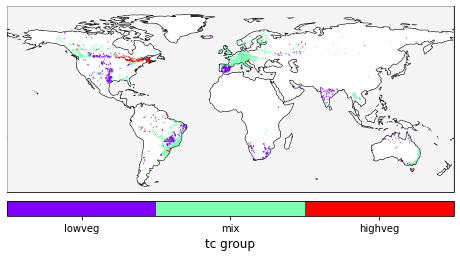

In [102]:
# map tree cover groups
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
df = df[df['sr_20']>0]
tc_groups = ['lowveg','mix','highveg']
df['tc_group'] = np.zeros(len(df))

df['tc_group'][(df.tc<0.15)] = 0
df['tc_group'][(df.tc>0.15)&(df.tc<0.5)] = 1
df['tc_group'][(df.tc>0.5)] = 2
# df['tc_group'][(df.tc>0.5)&(df.t_mean<20)] = 3

cmap_vd2 = cm.get_cmap('rainbow', 3)
bounds = np.linspace(0,3,4)
bounds2 = np.linspace(0,3,4)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,s=0.8,c=df['tc_group'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.02,aspect=30, norm=norm)
cbar.set_ticks([0.5,1.5,2.5])
cbar.set_ticklabels(['lowveg','mix','highveg'])
cbar.set_label(label='tc group', size=12)
ax.set_title('',size=14)
fig.savefig(f'{work_dir}/output/regression/tree_cover/tree_cover_groups_map.jpg', bbox_inches='tight',dpi=300)


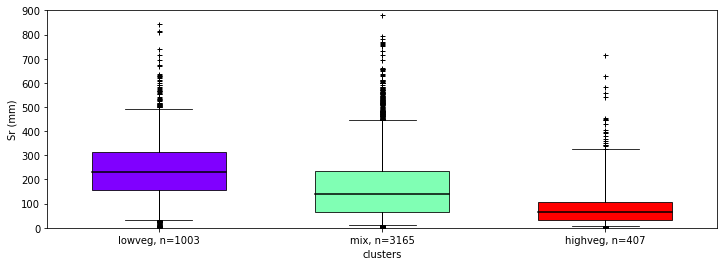

In [104]:
boxprops1 = dict(facecolor=cmap_vd2(0),color="black",linewidth=0.8)
boxprops2 = dict(facecolor=cmap_vd2(1),color="black",linewidth=0.8)
boxprops3 = dict(facecolor=cmap_vd2(2),color="black",linewidth=0.8)
medianprops = dict(color="black",linewidth=1.5)
flierprops = dict(color='black',marker='+',markersize=5)
capprops = dict(linestyle='-', linewidth=0.8, color='Black')

co1 = df[df.tc_group==0]
co2 = df[df.tc_group==1]
co3 = df[df.tc_group==2]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.boxplot(co1.sr_20,positions=[1],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.boxplot(co2.sr_20,positions=[2],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.boxplot(co3.sr_20,positions=[3],widths=0.6,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops3,medianprops=medianprops,flierprops=flierprops,capprops=capprops,zorder=0)
ax.xaxis.set_ticks([1,2,3])
ax.xaxis.set_ticklabels([f'lowveg, n={len(co1)}',f'mix, n={len(co2)}',f'highveg, n={len(co3)}'])
ax.set_ylabel('Sr (mm)')
ax.set_xlabel('clusters')
ax.set_ylim(0,900)
fig.savefig(f'{work_dir}/output/regression/tree_cover/treecover_sr_boxplot.jpg', bbox_inches='tight',dpi=300)


### tree cover groups - fix variables

In [106]:
# iterate over feature-combinations and over 4 tree cover groups
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['lpf','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','cvp','asi','slp_mean','el_mean','dtb']
ll = []
df = df[df['sr_20']>0]
tc_groups = ['lowveg','mix','highveg']
m = []
for i in range(len(tc_groups)):
    if (i==0):
        dfc = df[(df.tc<0.15)]
    if (i==1):
        dfc = df[(df.tc>0.15)&(df.tc<0.5)]
    if (i==2):
        dfc = df[(df.tc>0.5)]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = lin_regress(features,dfc,plot=False,cross_val=False)
    l.index = [tc_groups[i]]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)
mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
dd = pd.DataFrame(index=md.index)
dd[features] = md[features]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj', 'n_train', 'n_test','kfold_cv']] = md[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj',
                                                                                                        'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj', 'n_train', 'n_test','kfold_cv']]
dd[['tc_mean','ntc_mean','nonveg_mean']] = md[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = md[['sr_mean','sr_std']]
dd.to_csv(f'{work_dir}/output/regression/tree_cover/tc_regression_table_fixvar.csv')   

### tree cover bins

In [166]:
# iterate over feature-combinations and over tree cover bins
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
df = df.sort_values('tc')
features = ['lpf','tdiff_mean','t_mean','idu_mean','p_mean','si_p','pcarb','slp_mean','asi']#,'psand','pclay','dtb','ntc','nonveg']
all_combinations = get_combinations(features) # method call
ll = []
for j in all_combinations:
    df = df[df['sr_20']>0]
    features = list(j)
    m = []
    bins=10
    for i in range(bins):
        dfc = df.iloc[int((i*len(df))/bins):int(((i+1)*len(df))/bins)]
        dfc_tc = np.round(dfc.tc.mean(),2)
        dfc_ntc = np.round(dfc.ntc.mean(),2)
        dfc_nonveg = np.round(dfc.nonveg.mean(),2)
        dfc_srm = int(dfc.sr_20.mean())
        dfc_srs = int(dfc.sr_20.std())
        l = lin_regress(features,dfc,plot=False,cross_val=True)
        l.index = [i]
        l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
        l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
        m.append(l)
    mm = pd.concat(m)
    ll.append(mm)
md = pd.concat(ll)

In [ ]:
# select for each tree cover group the 5 feature combinations with the largest r2-adj and plot output
l = []
bins = 10
for i in range(bins):
    mdi = md.loc[i]
    mds = mdi.sort_values('test_r2_adj',ascending=False)[0:5]
    l.append(mds)
    mdsf = mds[features]
    for j in range(len(mds)):
        ft = mdsf.iloc[j].dropna().index.values
        dfc = df.iloc[int((i*len(df))/bins):int(((i+1)*len(df))/bins)]
        lin_regress(ft,dfc,plot=False,cross_val=True)
ll = pd.concat(l)
dd = pd.DataFrame(index=ll.index)
dd[features] = ll[features]
dd[['tc_mean','ntc_mean','nonveg_mean']] = ll[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = ll[['sr_mean','sr_std']]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = ll[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd.to_csv(f'{work_dir}/output/regression/tree_cover/tc_bins_regression_table.csv')

### tree cover bins - fix variables

In [87]:
# iterate over feature-combinations and over tree cover bins
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
df = df.sort_values('tc')
features = ['lpf','tdiff_mean','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','asi','dtb','ia','slp_mean','tc']
ll = []
df = df[df['sr_20']>0]
m = []
bins=10
for i in range(bins):
    dfc = df.iloc[int((i*len(df))/bins):int(((i+1)*len(df))/bins)]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = lin_regress(features,dfc,plot=False,cross_val=True)
    l.index = [i]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)
mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
dd = pd.DataFrame(index=md.index)
dd[features] = md[features]
dd[['tc_mean','ntc_mean','nonveg_mean']] = md[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = md[['sr_mean','sr_std']]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj', 'n_train', 'n_test','kfold_cv']] = md[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj', 'n_train', 'n_test','kfold_cv']]
dd.to_csv(f'{work_dir}/output/regression/tree_cover/tc_bins_regression_table_allvar.csv')

In [88]:
dd

lpf  idu_mean  si_ep  ep_mean  p_mean   si_p     tc  tc_mean  ntc_mean  \
0  0.693    -0.314  0.017    0.190   0.547  0.260  0.154     0.06      0.61   
1  0.235     0.067 -0.387   -0.158  -0.020  0.469  0.091     0.12      0.69   
2  0.649    -0.108 -0.841   -0.471   0.307  0.266 -0.025     0.16      0.67   
3  0.273     0.492 -0.280   -0.124   0.199 -0.044 -0.123     0.20      0.64   
4  0.281     0.369 -0.243   -0.128   0.173  0.069 -0.088     0.24      0.60   
5  0.406     0.205 -0.449   -0.318   0.053  0.148  0.012     0.28      0.58   
6  0.079     0.164  0.069    0.381  -0.076  0.124 -0.024     0.33      0.53   
7  0.229     0.288  0.248    0.466   0.242  0.129 -0.054     0.38      0.49   
8  0.024     0.629  0.178    0.136   0.387  0.109 -0.025     0.45      0.42   
9  0.264     0.231 -0.009    0.484   0.098  0.126  0.075     0.55      0.34   

   nonveg_mean  ...  train_r2  train_r2_adj  test_mse  test_rmse  test_mae  \
0         0.33  ...      0.47          0.46    6838.0       82.0      66.0   
1         0.19  ...      0.48          0.47   13219.0      114.0      85.0   
2         0.17  ...      0.44          0.43   10079.0      100.0      74.0   
3         0.16  ...      0.45          0.44   13672.0      116.0      91.0   
4         0.15  ...      0.34          0.33   12201.0      110.0      87.0   
5         0.14  ...      0.29          0.28   10347.0      101.0      77.0   
6         0.14  ...      0.24          0.23   10179.0      100.0      76.0   
7         0.13  ...      0.32          0.31   10944.0      104.0      79.0   
8         0.14  ...      0.38          0.37    6663.0       81.0      58.0   
9         0.11  ...      0.34          0.33    8356.0       91.0      51.0   

   test_r2  test_r2_adj  n_train  n_test  kfold_cv  
0     0.38         0.32      366      91         5  
1     0.47         0.42      367      91         5  
2     0.39         0.34      366      91         5  
3     0.35         0.30      367      91         5  
4     0.32         0.26      366      91         5  
5     0.25         0.19      367      91         5  
6     0.17         0.09      366      91         5  
7     0.28         0.22      367      91         5  
8     0.34         0.28      366      91         5  
9     0.26         0.20      367      91         5  

[10 rows x 25 columns]

### clusters fix variables

In [83]:
# iterate over feature-combinations and over tree cover bins
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
df = df.sort_values('tc')
features = ['lpf','tdiff_mean','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','asi','dtb','ia','slp_mean','tc']
# features = ['lpf','idu_mean','si_ep','ep_mean','p_mean','si_p','tc','pcarb']
# features = ['p_mean', 'ep_mean', 't_mean', 'ai', 'hai', 'tdiff_max', 'tdiff_mean',
#        'idu_mean', 'idu_max', 'hpd_mean', 'hpd_max', 'hpf', 'lpf', 'si_p',
#        'si_ep', 'phi', 'de', 'dp', 'dt', 'sp', 'st', 'se', 'sd', 'sti', 'ftf',
#        'asi', 'cvp', 'tc', 'ntc', 'nonveg', 'area', 'el_mean', 'el_min',
#        'el_max', 'el_std', 'slp_mean', 'slp_max', 'slp_min', 'slp_std', 'iwu',
#        'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk']
ll = []
df = df[df['sr_20']>0]
clusters = [0,1,2,3,4]
m = []
for i in clusters:
    dfc = df[df.cluster==i]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = lin_regress(features,dfc,plot=False,cross_val=False)
    l.index = [i]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)

mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
dd = pd.DataFrame(index=md.index)
dd[features] = md[features]
dd[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
    'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']] = md[['train_mse','train_rmse', 'train_mae', 'train_r2', 'train_r2_adj','train_aic',
                                                                                                           'test_mse','test_rmse', 'test_mae', 'test_r2', 'test_r2_adj','test_aic', 'n_train', 'n_test','kfold_cv']]
dd[['tc_mean','ntc_mean','nonveg_mean']] = md[['tc_mean','ntc_mean','nonveg_mean']]
dd[['sr_mean','sr_std']] = md[['sr_mean','sr_std']]
dd.to_csv(f'{work_dir}/output/regression/clusters/cluster_regression_allvar.csv')

## 4. Decision trees

In [79]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df = df.dropna()
df = df.sort_values('tc')
features = ['lpf','idu_mean','si_ep','ep_mean','p_mean','si_p','tc']
sr_rp = 'sr_20'
dfx = df[features].values
dfy = df[sr_rp].values
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1), test_size=0.33, random_state=42)
# scalery = StandardScaler().fit(y_train)
# scalerx = StandardScaler().fit(X_train)
# X_train, y_train = scalerx.transform(X_train),scalery.transform(y_train)
# X_test, y_test = scalerx.transform(X_test),scalery.transform(y_test)

ds = np.arange(1,20,1)
r2_train=[]
rmse_train=[]
r2_test=[]
rmse_test=[]
mae_train=[]
mae_test=[]
for i in ds:
    clf = tree.DecisionTreeRegressor(max_depth=i,random_state=42,min_samples_leaf=10)
    clf = clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    r2_train.append(clf.score(X_train,y_train))
    rmse_train.append(np.sqrt(((y_train-y_train_pred)**2).mean()))
    r2_test.append(clf.score(X_test,y_test))
    rmse_test.append(np.sqrt(((y_test-y_test_pred)**2).mean()))
    mae_train.append((y_train-y_train_pred).mean())
    mae_test.append((y_test-y_test_pred).mean())

In [80]:
dtdf = pd.DataFrame(columns=['max_depth','r2_train','rmse_train','mae_train','r2_test','rmse_test','mae_test'])
dtdf.max_depth = ds
dtdf.r2_train = r2_train
dtdf.rmse_train = rmse_train
dtdf.r2_test= r2_test
dtdf.rmse_test = rmse_test
dtdf.mae_train = mae_train
dtdf.mae_test = mae_test
# dtdf.round(2)

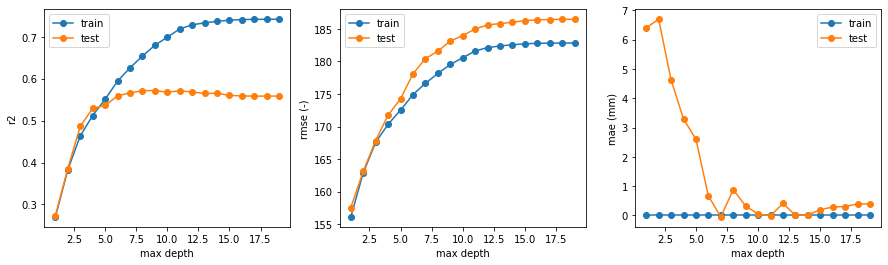

In [81]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(131)
ax.plot(ds,r2_train,'-o',label='train')
ax.plot(ds,r2_test,'-o',label='test')
ax.set_xlabel('max depth')
ax.set_ylabel('r2')
ax.legend()

ax = fig.add_subplot(132)
ax.plot(ds,rmse_train,'-o',label='train')
ax.plot(ds,rmse_test,'-o',label='test')
ax.set_xlabel('max depth')
ax.set_ylabel('rmse (-)')
ax.legend()

ax = fig.add_subplot(133)
ax.plot(ds,mae_train,'-o',label='train')
ax.plot(ds,mae_test,'-o',label='test')
ax.set_xlabel('max depth')
ax.set_ylabel('mae (mm)')
ax.legend()

Text(0, 0.5, 'Sr predicted (mm)')

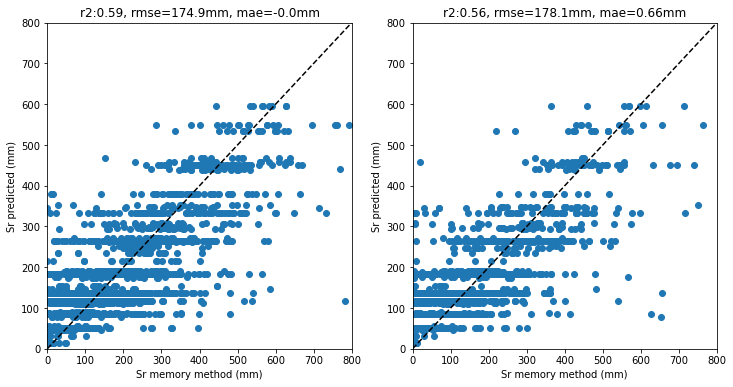

In [82]:
max_depth=6
min_samples_leaf=10
clf = tree.DecisionTreeRegressor(max_depth=max_depth,random_state=42,min_samples_leaf=min_samples_leaf)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

r2_train = np.round(clf.score(X_train,y_train),2)
rmse_train=np.round(np.sqrt(((y_train-y_train_pred)**2).mean()),2)
mae_train=np.round((y_train-y_train_pred).mean(),2)

r2_test = np.round(clf.score(X_test,y_test),2)
rmse_test=np.round(np.sqrt(((y_test-y_test_pred)**2).mean()),2)
mae_test=np.round((y_test-y_test_pred).mean(),2)
    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(y_train,y_train_pred,'o')
ax.plot([0,800],[0,800],'k--')
ax.set_title(f'r2:{r2_train}, rmse={rmse_train}mm, mae={mae_train}mm')
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_xlabel('Sr memory method (mm)')
ax.set_ylabel('Sr predicted (mm)')

ax = fig.add_subplot(122)
ax.plot(y_test,y_test_pred,'o')
ax.plot([0,800],[0,800],'k--')
ax.set_title(f'r2:{r2_test}, rmse={rmse_test}mm, mae={mae_test}mm')
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_xlabel('Sr memory method (mm)')
ax.set_ylabel('Sr predicted (mm)')


Text(0, 0.5, 'feature importance')

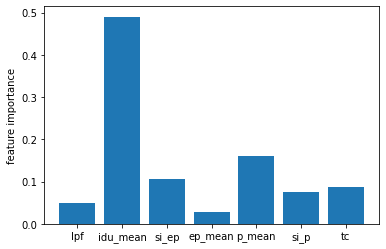

In [83]:
fi = clf.feature_importances_
plt.bar(features,fi)
plt.ylabel('feature importance')

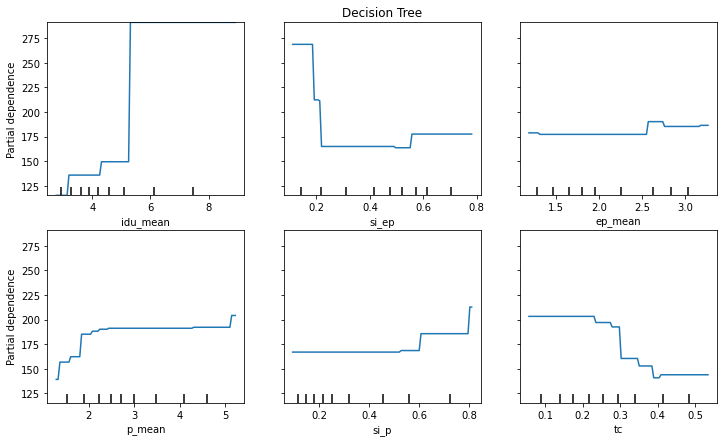

In [92]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title("Decision Tree")
tree_disp = PartialDependenceDisplay.from_estimator(clf, X_test, [1,2,3,4,5,6],feature_names=features, ax=ax)
# ax.set_xlim(

In [10]:
# fig = plt.figure(figsize=(20,10))
# tree.plot_tree(clf,feature_names=features,filled=True)

## 5. Random forest

In [94]:
def rf_regression(df,features,min_samples_leaf,max_depth,plot):
    sr_rp = 'sr_20'
    dfx = df[features].values
    dfy = df[sr_rp].values

    X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.5, random_state=42)
    
    rf = RandomForestRegressor(random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)

    train_mse = int(mean_squared_error(y_train, train_y_pred))
    train_mae = int(mean_absolute_error(y_train, train_y_pred))
    train_r2 = np.round(r2_score(y_train, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
    train_rmse = int(rmse(y_train,train_y_pred))
    train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

    test_mse = int(mean_squared_error(y_test, test_y_pred))
    test_mae = int(mean_absolute_error(y_test, test_y_pred))
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_rmse = int(rmse(y_test,test_y_pred))
    test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)
    
    n_test = len(y_test)
    n_train = len(y_train)

    sdf = pd.DataFrame(index=[0])
    sdf[features] = np.round(rf.feature_importances_,2)
    sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
    sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
    sdf[['n_train','n_test']] = [n_train,n_test]
    
    if (plot==True):
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(121)
        ax.plot(y_train,train_y_pred,'o')
        ax.plot([0,800],[0,800],'k--')
        ax.set_title(f'r2:{train_r2}, rmse={train_rmse}mm, mae={train_mae}mm')
        ax.set_xlim(0,800)
        ax.set_ylim(0,800)
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')

        ax = fig.add_subplot(122)
        ax.plot(y_test,test_y_pred,'o')
        ax.plot([0,800],[0,800],'k--')
        ax.set_title(f'r2:{test_r2}, rmse={test_rmse}mm, mae={test_mae}mm')
        ax.set_xlim(0,800)
        ax.set_ylim(0,800)
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')
        
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.set_title("Random forest partial dependences")
        tree_disp = PartialDependenceDisplay.from_estimator(rf, X_test, range(len(features)),feature_names=features, ax=ax)
    return sdf

In [92]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df = df.dropna()
# df = df[df.tc>0.50]
# df = df.sort_values('tc')
features = ['lpf','idu_mean','si_ep','ep_mean','p_mean','si_p','tc']
sr_rp = 'sr_20'
dfx = df[features].values
dfy = df[sr_rp].values
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.33, random_state=42)
r2_train=[]
rmse_train=[]
r2_test=[]
r2_adj_train=[]
r2_adj_test=[]
mse_train=[]
mae_train=[]
mse_test=[]
mae_test=[]
mape_train=[]
mape_test=[]
rmse_test=[]
mae_train=[]
mae_test=[]
ds = [10,20,30,40,50,80,100,150,200]
for i in ds:
    rf = RandomForestRegressor(random_state=42,min_samples_leaf=i,max_depth=6)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)
    
    train_mse = int(mean_squared_error(y_train, train_y_pred))
    train_mae = int(mean_absolute_error(y_train, train_y_pred))
    train_r2 = np.round(r2_score(y_train, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
    train_rmse = int(rmse(y_train,train_y_pred))
    train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)
    
    test_mse = int(mean_squared_error(y_test, test_y_pred))
    test_mae = int(mean_absolute_error(y_test, test_y_pred))
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_rmse = int(rmse(y_test,test_y_pred))
    test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)
    
    r2_train.append(train_r2)
    r2_adj_train.append(train_r2_adj)
    rmse_train.append(train_rmse)
    mae_train.append(train_mae)
    mse_train.append(train_mse)
    mape_train.append(train_mape)
    
    r2_test.append(test_r2)
    r2_adj_test.append(test_r2_adj)
    rmse_test.append(test_rmse)
    mae_test.append(test_mae)
    mse_test.append(test_mse)
    mape_test.append(test_mape)
    
    n_test = len(y_test)
    n_train = len(y_train)

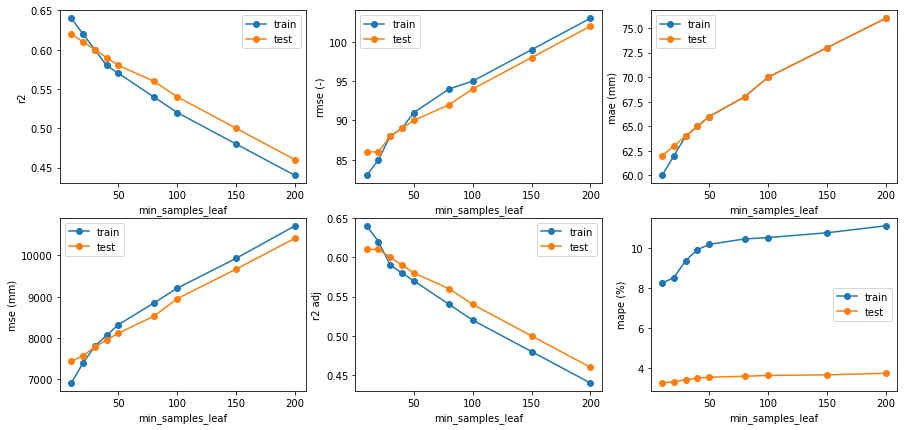

In [93]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(231)
ax.plot(ds,r2_train,'-o',label='train')
ax.plot(ds,r2_test,'-o',label='test')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('r2')
ax.legend()

ax = fig.add_subplot(232)
ax.plot(ds,rmse_train,'-o',label='train')
ax.plot(ds,rmse_test,'-o',label='test')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('rmse (-)')
ax.legend()

ax = fig.add_subplot(233)
ax.plot(ds,mae_train,'-o',label='train')
ax.plot(ds,mae_test,'-o',label='test')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('mae (mm)')
ax.legend()

ax = fig.add_subplot(234)
ax.plot(ds,mse_train,'-o',label='train')
ax.plot(ds,mse_test,'-o',label='test')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('mse (mm)')
ax.legend()

ax = fig.add_subplot(235)
ax.plot(ds,r2_adj_train,'-o',label='train')
ax.plot(ds,r2_adj_test,'-o',label='test')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('r2 adj')
ax.legend()

ax = fig.add_subplot(236)
ax.plot(ds,mape_train,'-o',label='train')
ax.plot(ds,mape_test,'-o',label='test')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('mape (%)')
ax.legend()

In [94]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df = df.dropna()
# df = df[df.tc>0.50]
# df = df.sort_values('tc')
features = ['lpf','ep_mean','si_ep','idu_mean','p_mean','si_p','asi','slp_mean','pcarb']
sr_rp = 'sr_20'
dfx = df[features].values
dfy = df[sr_rp].values
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.33, random_state=42)
r2_train=[]
rmse_train=[]
r2_test=[]
r2_adj_train=[]
r2_adj_test=[]
mse_train=[]
mae_train=[]
mse_test=[]
mae_test=[]
mape_train=[]
mape_test=[]
rmse_test=[]
mae_train=[]
mae_test=[]
md = [2,3,4,5,6,7,8,9,10,15,20]
for i in md:
    rf = RandomForestRegressor(random_state=42,min_samples_leaf=30,max_depth=i)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)
    
    train_mse = int(mean_squared_error(y_train, train_y_pred))
    train_mae = int(mean_absolute_error(y_train, train_y_pred))
    train_r2 = np.round(r2_score(y_train, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
    train_rmse = int(rmse(y_train,train_y_pred))
    train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)
    
    test_mse = int(mean_squared_error(y_test, test_y_pred))
    test_mae = int(mean_absolute_error(y_test, test_y_pred))
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_rmse = int(rmse(y_test,test_y_pred))
    test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)
    
    r2_train.append(train_r2)
    r2_adj_train.append(train_r2_adj)
    rmse_train.append(train_rmse)
    mae_train.append(train_mae)
    mse_train.append(train_mse)
    mape_train.append(train_mape)
    
    r2_test.append(test_r2)
    r2_adj_test.append(test_r2_adj)
    rmse_test.append(test_rmse)
    mae_test.append(test_mae)
    mse_test.append(test_mse)
    mape_test.append(test_mape)
    
    n_test = len(y_test)
    n_train = len(y_train)

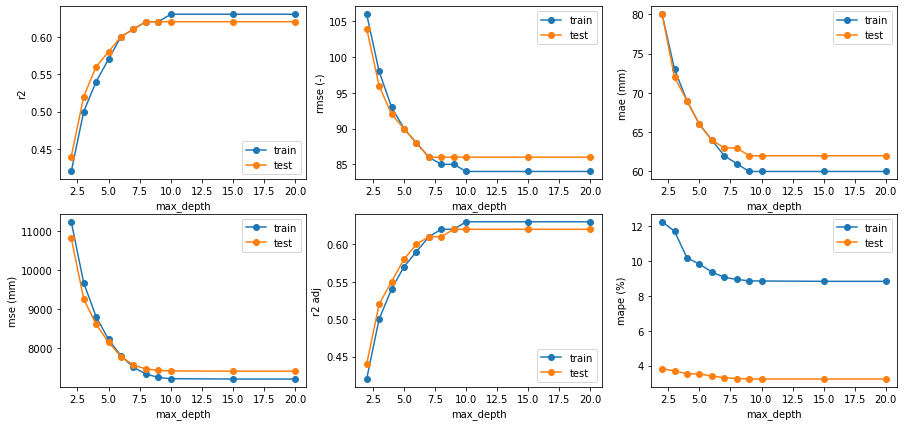

In [95]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(231)
ax.plot(md,r2_train,'-o',label='train')
ax.plot(md,r2_test,'-o',label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('r2')
ax.legend()

ax = fig.add_subplot(232)
ax.plot(md,rmse_train,'-o',label='train')
ax.plot(md,rmse_test,'-o',label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('rmse (-)')
ax.legend()

ax = fig.add_subplot(233)
ax.plot(md,mae_train,'-o',label='train')
ax.plot(md,mae_test,'-o',label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('mae (mm)')
ax.legend()

ax = fig.add_subplot(234)
ax.plot(md,mse_train,'-o',label='train')
ax.plot(md,mse_test,'-o',label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('mse (mm)')
ax.legend()

ax = fig.add_subplot(235)
ax.plot(md,r2_adj_train,'-o',label='train')
ax.plot(md,r2_adj_test,'-o',label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('r2 adj')
ax.legend()

ax = fig.add_subplot(236)
ax.plot(md,mape_train,'-o',label='train')
ax.plot(md,mape_test,'-o',label='test')
ax.set_xlabel('max_depth')
ax.set_ylabel('mape (%)')
ax.legend()

In [239]:
# run random forest with fixed hyperparameters
min_samples_leaf=30
max_depth=7
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df = df.dropna()
features = ['lpf','ep_mean','si_ep','idu_mean','p_mean','si_p','asi','slp_mean','pcarb']
sdf = rf_regression(df,features,min_samples_leaf,max_depth,plot=False)
sdf.to_csv(f'{work_dir}/output/regression/rf_regression_table_md{max_depth}_msl{min_samples_leaf}.csv')
sdf

lpf  ep_mean  si_ep  idu_mean  p_mean  si_p   asi  slp_mean  pcarb  \
0  0.02     0.03   0.04       0.5    0.14  0.06  0.05      0.04   0.14   

   train_mse  ...  train_r2_adj  train_mape  test_mse  test_rmse  test_mae  \
0       6907  ...          0.64        8.08      7121         84        59   

   test_r2  test_r2_adj  test_mape  n_train  n_test  
0     0.63         0.63       3.06     3065    1510  

[1 rows x 23 columns]

In [98]:
# select which features are less and more than average important for regression
# from sklearn.feature_selection import SelectFromModel
# sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
# sel.fit(X_train, y_train)
# sel.get_support()

NameError: name 'y_train_pred' is not defined

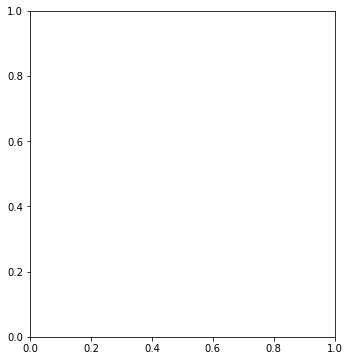

In [99]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(y_train,y_train_pred,'o')
ax.plot([0,800],[0,800],'k--')
ax.set_title(f'r2:{r2_train}, rmse={rmse_train}mm, mae={mae_train}mm')
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_xlabel('Sr memory method (mm)')
ax.set_ylabel('Sr predicted (mm)')

ax = fig.add_subplot(122)
ax.plot(y_test,y_test_pred,'o')
ax.plot([0,800],[0,800],'k--')
ax.set_title(f'r2:{r2_test}, rmse={rmse_test}mm, mae={mae_test}mm')
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_xlabel('Sr memory method (mm)')
ax.set_ylabel('Sr predicted (mm)')

Text(0, 0.5, 'feature importance')

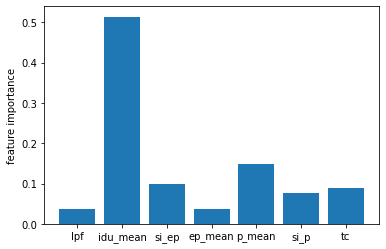

In [100]:
fi = rf.feature_importances_
plt.bar(features,fi)
plt.ylabel('feature importance')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Random forest partial dependences")
tree_disp = PartialDependenceDisplay.from_estimator(rf, X_test, [0,1,2,3,4,5,6],feature_names=features, ax=ax)

### all catchments

In [110]:
# run random forest with fixed hyperparameters
min_samples_leaf=30
max_depth=7
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df = df.dropna()
features = ['lpf','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','cvp','asi','slp_mean','el_mean','dtb']
sdf = rf_regression(df,features,min_samples_leaf,max_depth,plot=False)
sdf.to_csv(f'{work_dir}/output/regression/rf_regression_table_md{max_depth}_msl{min_samples_leaf}.csv')
sdf

lpf  t_mean  idu_mean  p_mean  pclay  psand  pcarb  bulk  si_p   cvp  ...  \
0  0.02    0.07      0.46    0.09   0.02   0.01   0.11  0.03  0.05  0.05  ...   

   train_r2_adj  train_mape  test_mse  test_rmse  test_mae  test_r2  \
0          0.66        7.85      7814         88        62      0.6   

   test_r2_adj  test_mape  n_train  n_test  
0          0.6        4.5     2287    2288  

[1 rows x 28 columns]

## climate clusters

In [95]:
min_samples_leaf=30
max_depth=7
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df = df.dropna()
features = ['tc', 'el_mean','slp_mean', 'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk']
sdf = rf_regression(df,features,min_samples_leaf,max_depth,plot=False)
sdf.to_csv(f'{work_dir}/output/regression/cl_clusters/rf_regression_table_md{max_depth}_msl{min_samples_leaf}.csv')
sdf

tc  el_mean  slp_mean    ia    bp   dtb  pclay  psand  pcarb  bulk  ...  \
0  0.05     0.04      0.04  0.07  0.01  0.08   0.09   0.05   0.52  0.06  ...   

   train_r2_adj  train_mape  test_mse  test_rmse  test_mae  test_r2  \
0          0.54        9.34     11076        105        74     0.44   

   test_r2_adj  test_mape  n_train  n_test  
0         0.44        4.8     2287    2288  

[1 rows x 24 columns]

In [100]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
# features = ['lpf','si_ep','ep_mean','idu_mean','p_mean','si_p','tc','pcarb']
features = ['tc', 'el_mean','slp_mean', 'ia', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk']
ll = []
min_samples_leaf=30
max_depth=7
df = df[df['sr_20']>0]
clusters = [0,1,2,3,4]
m = []
for i in clusters:
    dfc = df[df.cluster==i]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l =  rf_regression(dfc,features,min_samples_leaf,max_depth,plot=False)
    l.index = [i]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)
mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
md.to_csv(f'{work_dir}/output/regression/cl_clusters/rf_regression_table_md{max_depth}_msl{min_samples_leaf}_clusters.csv')

In [101]:
md

tc  el_mean  slp_mean    ia   bp   dtb  pclay  psand  pcarb  bulk  ...  \
0  0.46     0.19      0.01  0.03  0.0  0.01   0.02   0.20   0.05  0.02  ...   
1  0.04     0.01      0.03  0.01  0.0  0.46   0.02   0.04   0.35  0.05  ...   
2  0.27     0.23      0.14  0.00  0.0  0.00   0.11   0.00   0.24  0.00  ...   
3  0.38     0.04      0.11  0.09  0.0  0.03   0.05   0.03   0.16  0.13  ...   
4  0.00     0.01      0.13  0.04  0.0  0.62   0.15   0.01   0.00  0.04  ...   

   test_r2  test_r2_adj  test_mape  n_train  n_test  tc_mean  ntc_mean  \
0     0.27         0.25       0.89      328     329     0.16      0.61   
1     0.37         0.36       4.08      552     552     0.29      0.61   
2     0.29         0.25       0.40      182     183     0.14      0.66   
3     0.35         0.34       8.52      912     912     0.33      0.51   
4     0.48         0.46       8.71      312     313     0.30      0.50   

   nonveg_mean  sr_mean  sr_std  
0         0.23      253     125  
1         0.10      202     123  
2         0.20      408     153  
3         0.16      113      89  
4         0.19      111      75  

[5 rows x 29 columns]

## group clusters

In [86]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
# features = ['lpf','si_ep','ep_mean','idu_mean','p_mean','si_p','tc','pcarb']
features = ['lpf','tdiff_mean','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','asi','dtb','ia','slp_mean','tc']
ll = []
min_samples_leaf=30
max_depth=7
df = df[df['sr_20']>0]
clusters = [0,1,2,3,4]
m = []
for i in clusters:
    dfc = df[df.cluster==i]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l =  rf_regression(dfc,features,min_samples_leaf,max_depth,plot=False)
    l.index = [i]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)
mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
md.to_csv(f'{work_dir}/output/regression/rf_regression_table_md{max_depth}_msl{min_samples_leaf}_clusters.csv')

## group tree cover

In [109]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
features = ['lpf','t_mean','idu_mean','p_mean','pclay','psand','pcarb','bulk','si_p','cvp','asi','slp_mean','el_mean','dtb']
all_combinations = get_combinations(features) # method call
ll = []
min_samples_leaf=10
max_depth=7
df = df[df['sr_20']>0]
tc_groups = ['lowveg','mix','highveg']
m = []
for i in range(len(tc_groups)):
    if (i==0):
        dfc = df[(df.tc<0.15)]
    if (i==1):
        dfc = df[(df.tc>0.15)&(df.tc<0.5)]
    if (i==2):
        dfc = df[(df.tc>0.5)]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = rf_regression(dfc,features,min_samples_leaf,max_depth,plot=False)
    l.index = [tc_groups[i]]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)
mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
md.to_csv(f'{work_dir}/output/regression/tree_cover/rf_regression_table_md{max_depth}_msl{min_samples_leaf}_treecovergroups.csv')

## group tree cover bins

lpf  idu_mean  si_ep  ep_mean  p_mean  si_p  train_mse  train_rmse  \
0  0.02      0.21   0.14     0.27    0.14  0.21       2938          54   
1  0.09      0.21   0.11     0.18    0.10  0.30       5004          70   
2  0.14      0.12   0.30     0.17    0.10  0.16       4498          67   
3  0.06      0.63   0.15     0.04    0.04  0.07       4819          69   
4  0.10      0.53   0.09     0.12    0.06  0.09       5878          76   
5  0.06      0.55   0.07     0.10    0.11  0.10       4456          66   
6  0.09      0.18   0.11     0.28    0.08  0.27       4650          68   
7  0.07      0.26   0.17     0.22    0.13  0.15       4846          69   
8  0.12      0.28   0.09     0.06    0.07  0.39       3561          59   
9  0.14      0.08   0.27     0.35    0.09  0.07       3554          59   

   train_mae  train_r2  ...  test_r2  test_r2_adj  test_mape  n_train  n_test  \
0         39      0.76  ...     0.57         0.55       0.71      306     151   
1         49      0.77  ...     0.68         0.67       6.59      306     152   
2         47      0.76  ...     0.59         0.58       5.18      306     151   
3         48      0.79  ...     0.58         0.56       6.50      306     152   
4         55      0.68  ...     0.53         0.51       2.08      306     151   
5         50      0.71  ...     0.22         0.19       2.39      306     152   
6         46      0.64  ...     0.42         0.39      82.89      306     151   
7         46      0.69  ...     0.46         0.44      10.36      306     152   
8         38      0.66  ...     0.49         0.47       1.81      306     151   
9         34      0.59  ...     0.24         0.21       5.70      306     152   

   tc_mean  ntc_mean  nonveg_mean  sr_mean  sr_std  
0     0.06      0.61         0.33      208     112  
1     0.12      0.69         0.19      271     148  
2     0.16      0.67         0.17      249     134  
3     0.20      0.64         0.16      229     151  
4     0.24      0.60         0.15      197     132  
5     0.28      0.58         0.14      172     119  
6     0.33      0.53         0.14      135     112  
7     0.38      0.49         0.13      133     127  
8     0.45      0.42         0.14       91      98  
9     0.55      0.34         0.11       91     103  

[10 rows x 25 columns]

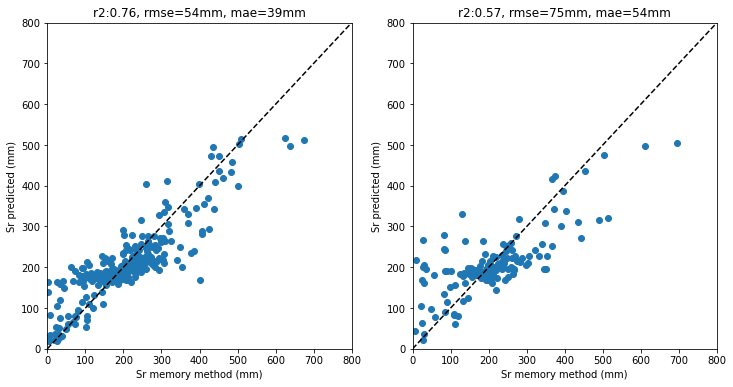

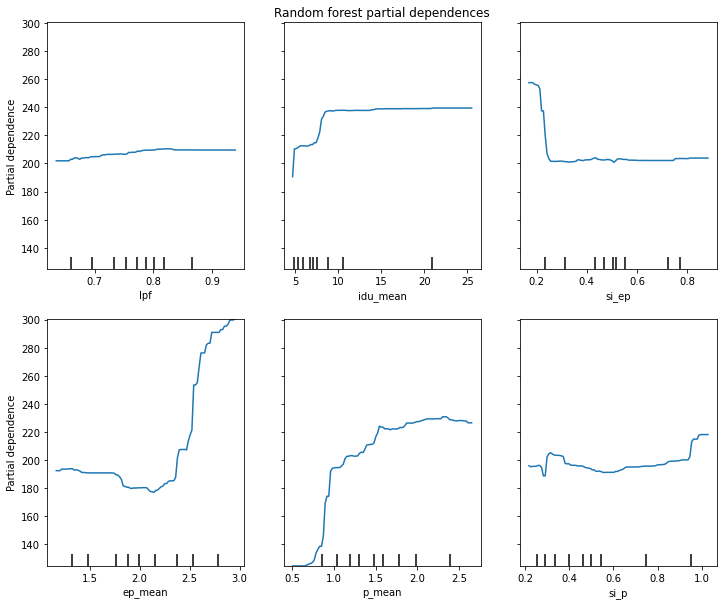

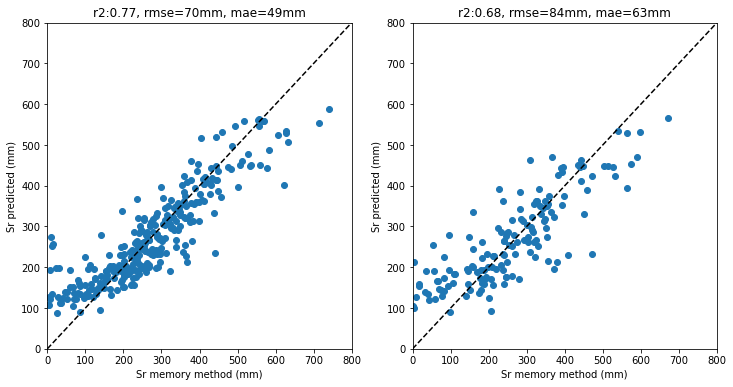

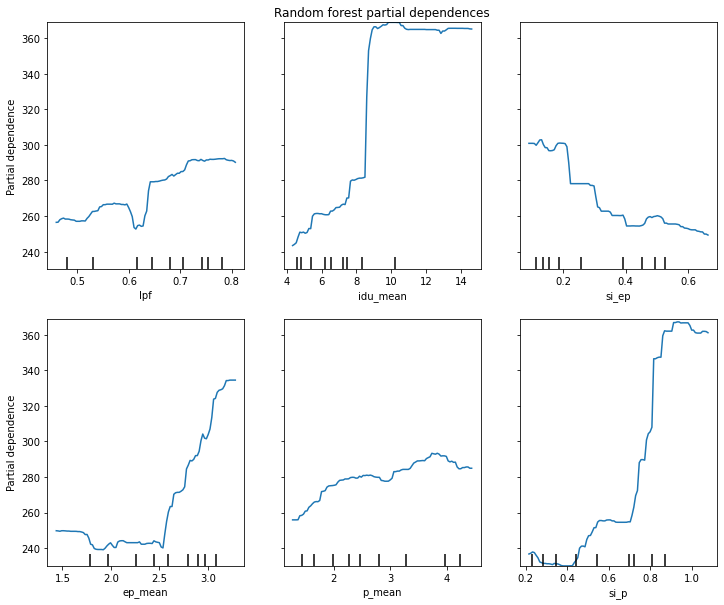

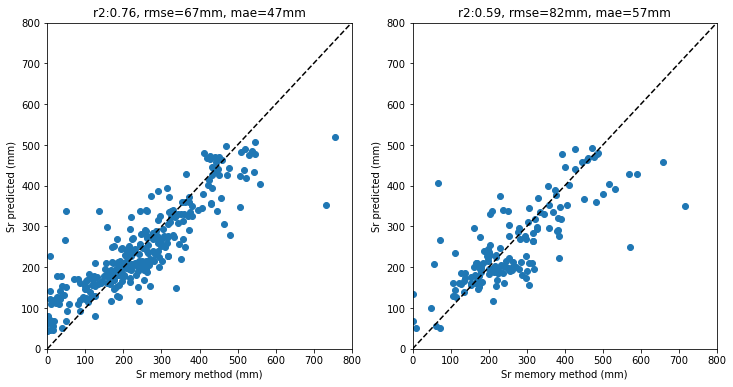

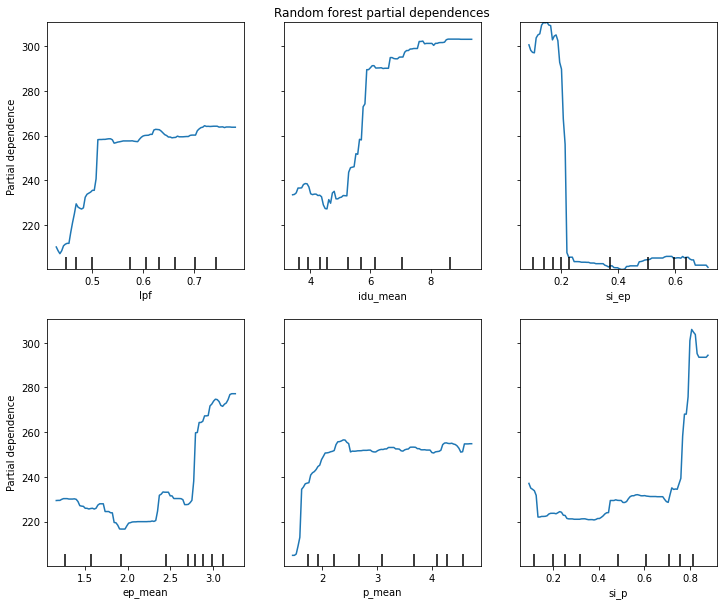

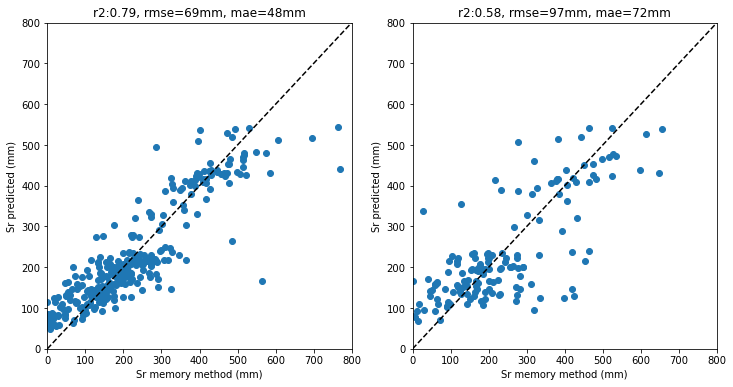

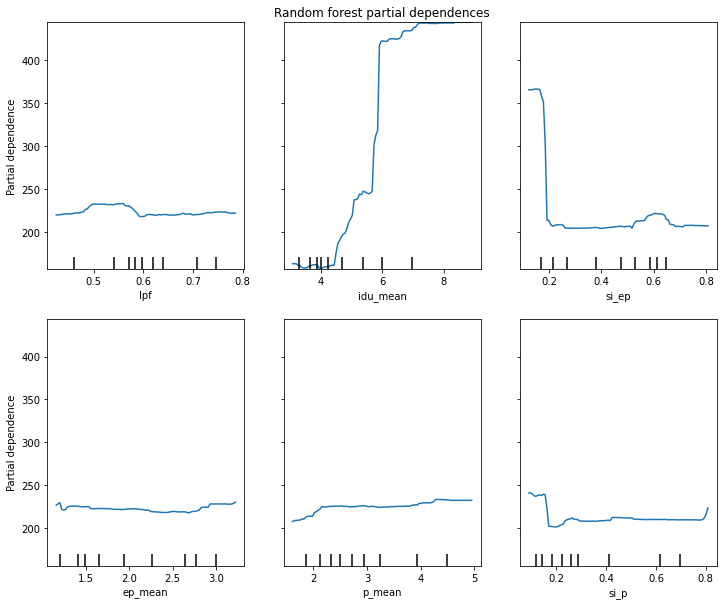

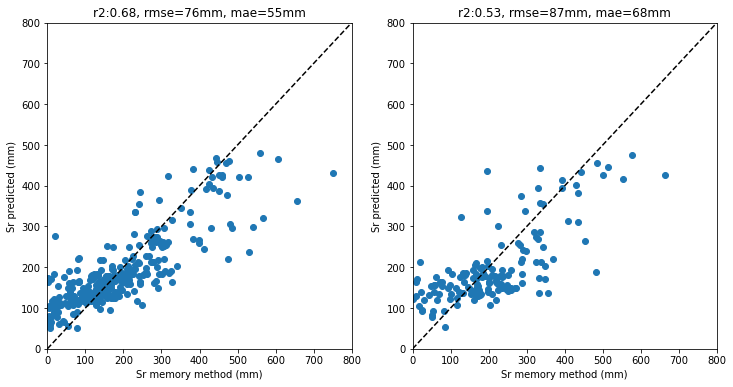

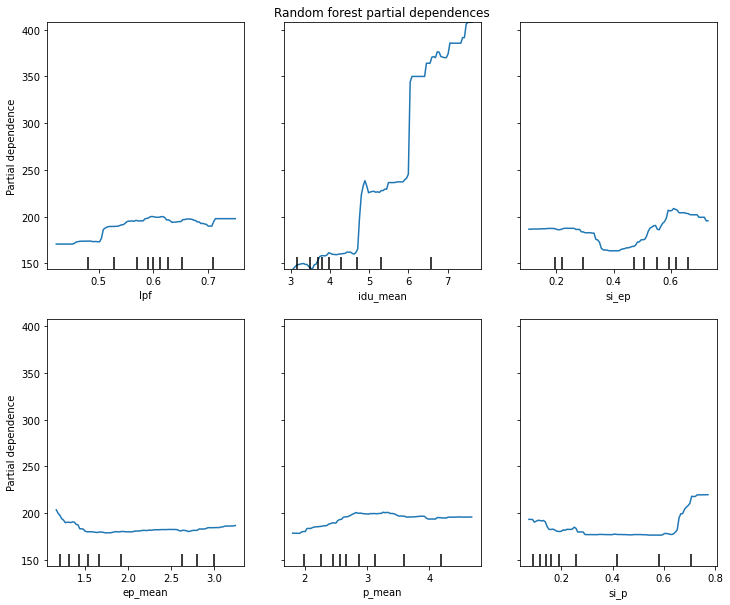

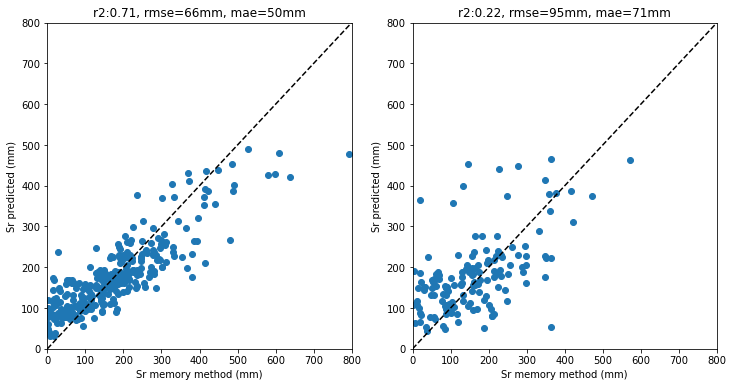

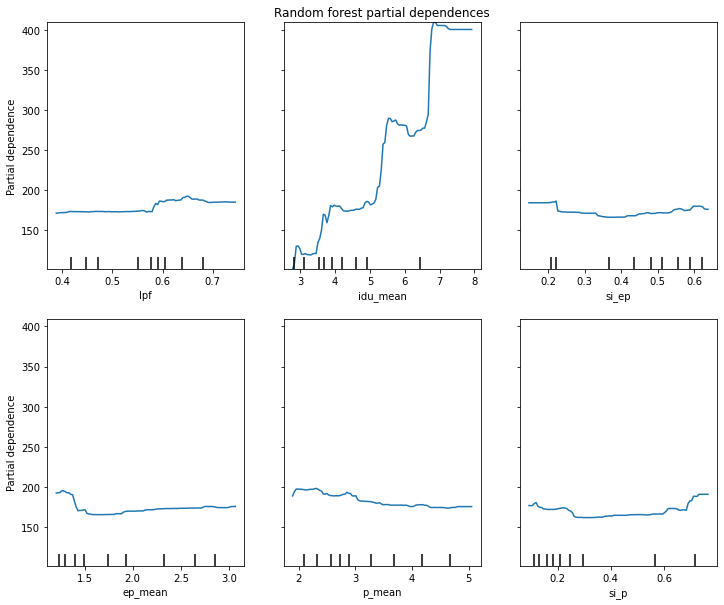

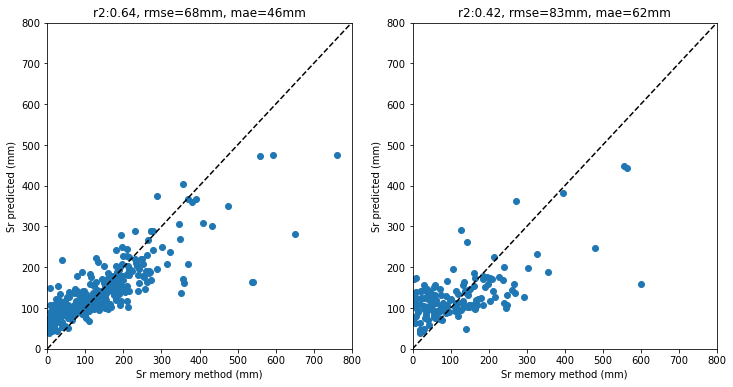

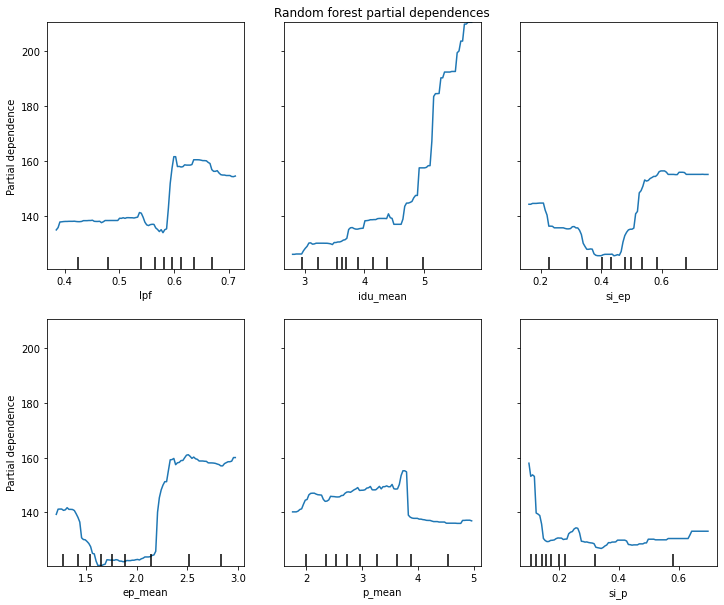

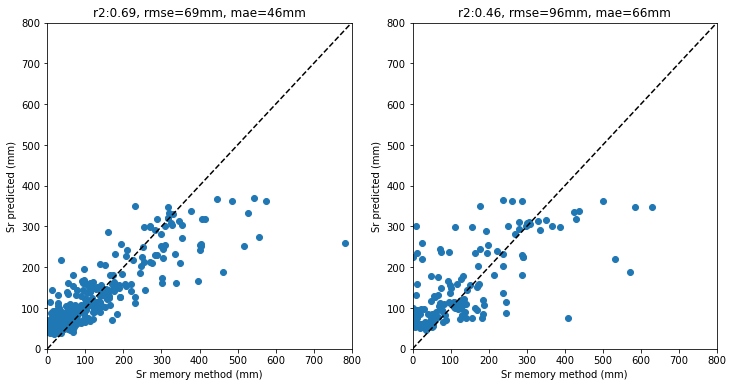

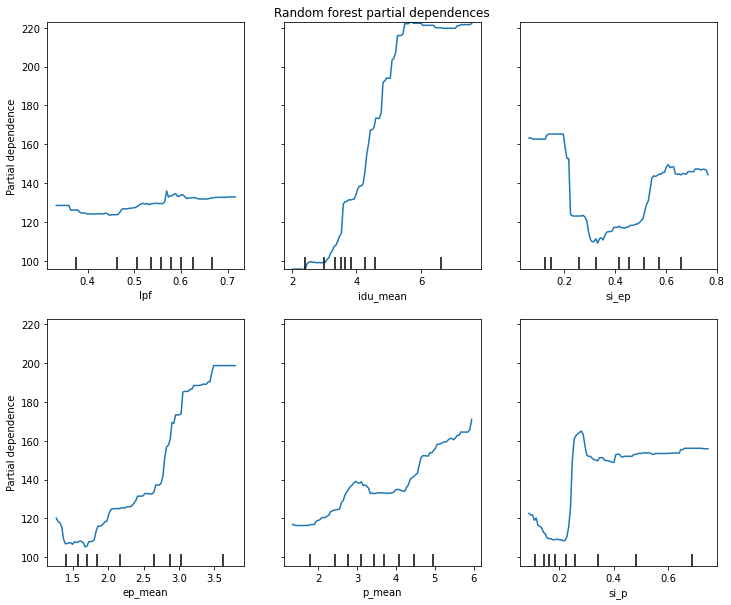

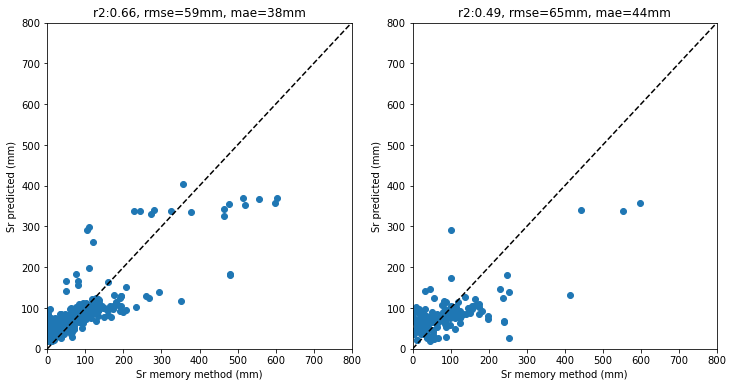

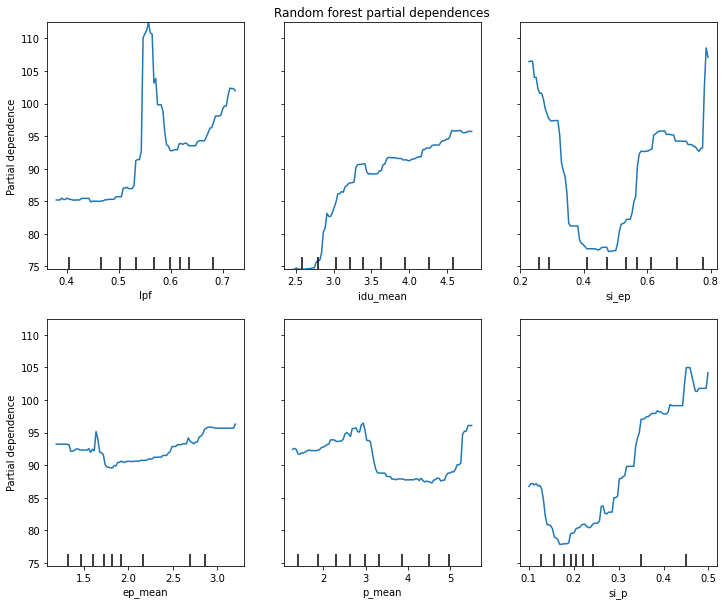

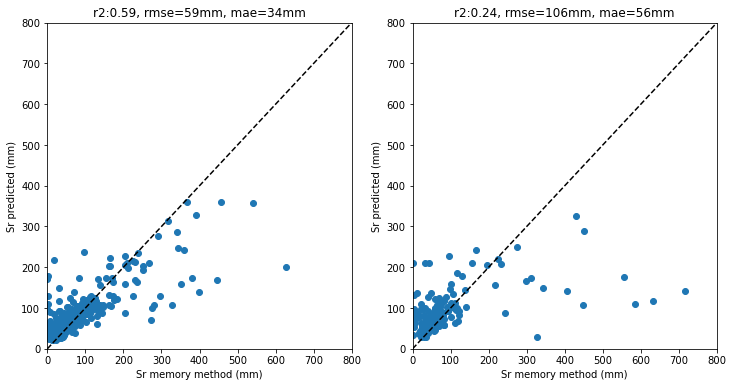

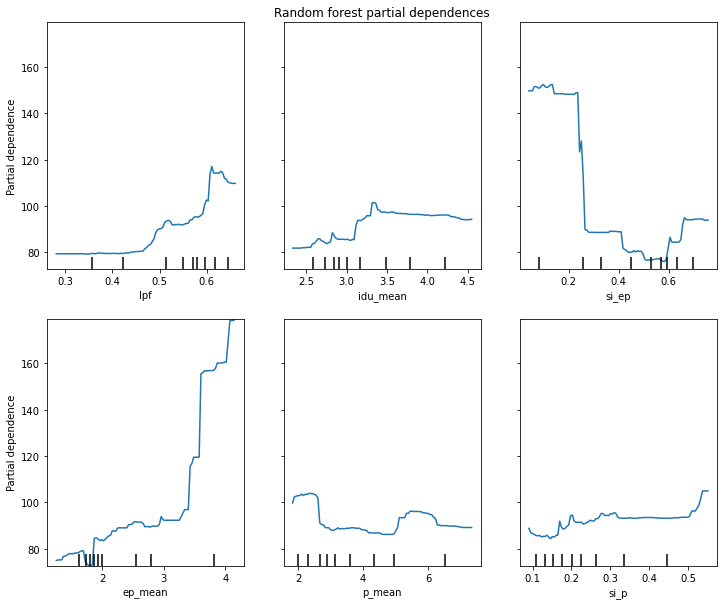

In [152]:
# iterate over feature-combinations and over tree cover bins
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
df = df.sort_values('tc')
min_samples_leaf=5
max_depth=7
features = ['lpf','idu_mean','si_ep','ep_mean','p_mean','si_p']
all_combinations = get_combinations(features) # method call
ll = []
df = df[df['sr_20']>0]
m = []
bins=10
for i in range(bins):
    dfc = df.iloc[int((i*len(df))/bins):int(((i+1)*len(df))/bins)]
    dfc_tc = np.round(dfc.tc.mean(),2)
    dfc_ntc = np.round(dfc.ntc.mean(),2)
    dfc_nonveg = np.round(dfc.nonveg.mean(),2)
    dfc_srm = int(dfc.sr_20.mean())
    dfc_srs = int(dfc.sr_20.std())
    l = rf_regression(dfc,features,min_samples_leaf,max_depth,plot=False)
    l.index = [i]
    l[['tc_mean','ntc_mean','nonveg_mean']] = dfc_tc,dfc_ntc,dfc_nonveg
    l[['sr_mean','sr_std']] = dfc_srm,dfc_srs
    m.append(l)
mm = pd.concat(m)
ll.append(mm)
md = pd.concat(ll)
md.to_csv(f'{work_dir}/output/regression/rf_regression_table_md{max_depth}_msl{min_samples_leaf}_treecoverbins.csv')
md

Text(0, 0.5, 'Sr predicted (mm)')

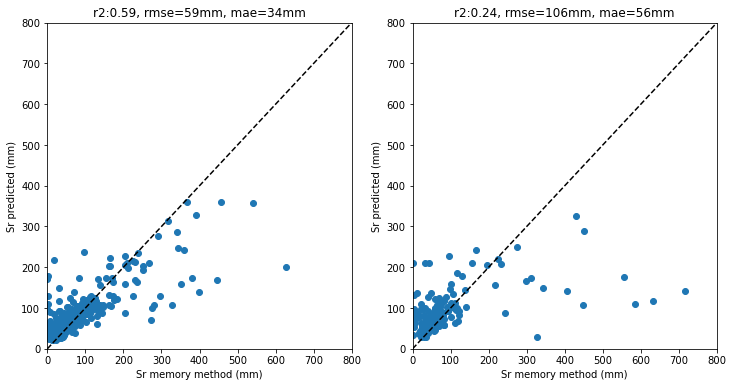

In [161]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_clusters.csv',index_col=0)
df = df.dropna()
df = df.sort_values('tc')

min_samples_leaf=5
max_depth=7
features = ['lpf','idu_mean','si_ep','ep_mean','p_mean','si_p']
df = df[df['sr_20']>0]
bins=10
i=9
dfc = df.iloc[int((i*len(df))/bins):int(((i+1)*len(df))/bins)]
df = dfc
sr_rp = 'sr_20'
dfx = df[features].values
dfy = df[sr_rp].values

X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.33, random_state=42)

rf = RandomForestRegressor(random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)
train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(mean_absolute_error(y_train, train_y_pred))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(mean_absolute_error(y_test, test_y_pred))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)
    

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(y_train,train_y_pred,'o')
ax.plot([0,800],[0,800],'k--')
ax.set_title(f'r2:{train_r2}, rmse={train_rmse}mm, mae={train_mae}mm')
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_xlabel('Sr memory method (mm)')
ax.set_ylabel('Sr predicted (mm)')

ax = fig.add_subplot(122)
ax.plot(y_test,test_y_pred,'o')
ax.plot([0,800],[0,800],'k--')
ax.set_title(f'r2:{test_r2}, rmse={test_rmse}mm, mae={test_mae}mm')
ax.set_xlim(0,800)
ax.set_ylim(0,800)
ax.set_xlabel('Sr memory method (mm)')
ax.set_ylabel('Sr predicted (mm)')

Text(0, 0.5, 'feature importance')

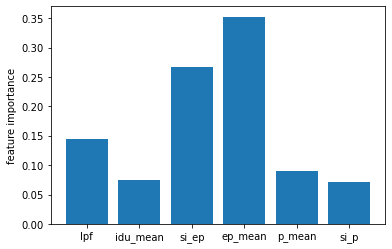

In [162]:
fi = rf.feature_importances_
plt.bar(features,fi)
plt.ylabel('feature importance')

In [163]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [164]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

In [171]:
i = 100
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[i], feature_names=features)

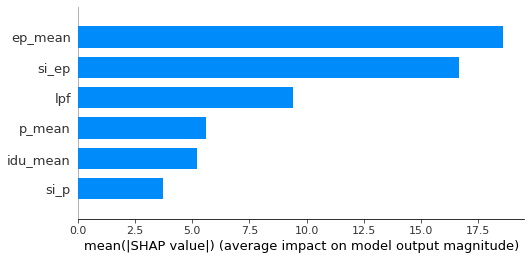

In [167]:
shap.summary_plot(shap_values, features=X_train, feature_names=features, plot_type='bar')

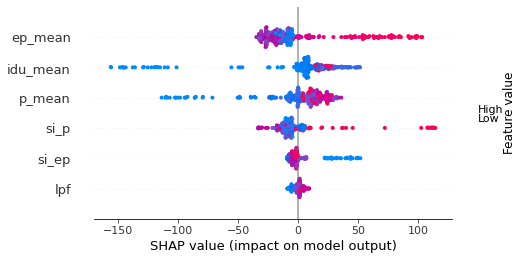

In [159]:
# color is feature value, red=high, blue=low
# shap value represents impact on model output + or -
# from top to bottom reducing feature importance
# dots are shap value for each feature for each sample
shap.summary_plot(shap_values, features=X_train, feature_names=features)


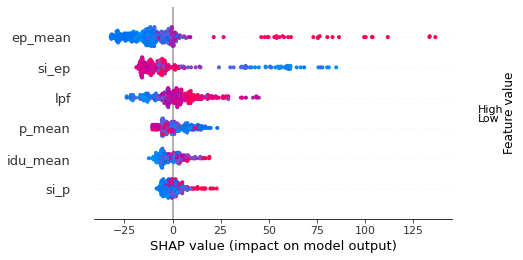

In [165]:
shap.summary_plot(shap_values, features=X_train, feature_names=features)


## 6. Hahm scripts random forest

In [12]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.dropna()

In [14]:
from sklearn.model_selection import train_test_split

target = df['sr_20']
predictors = ['p_mean','ep_mean','cvp','asi']
# predictors = ['lpf', 'idu_mean', 'si_ep', 'ep_mean', 'p_mean', 'si_p']
# predictors = ['idu_mean','si_ep','ep_mean','si_p','p_mean','tc']
pred_df = df[predictors]


X_train, X_valid, y_train, y_valid = train_test_split(pred_df.values, 
                                                      target.values, 
                                                      random_state=42)
MIN_SAMPLES_LEAF = 100

m = RandomForestRegressor(
                          n_jobs=-1, 
                          min_samples_leaf=MIN_SAMPLES_LEAF,
                          oob_score=True)
m_all = RandomForestRegressor(
                          min_samples_leaf=MIN_SAMPLES_LEAF,
                          n_jobs=-1, 
                          oob_score=True)
m.fit(X_train, y_train)
m_all.fit(pred_df.values,target.values)

RandomForestRegressor(min_samples_leaf=100, n_jobs=-1, oob_score=True)

In [15]:
def rmse(x,y): 
    return np.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
                       
print_score(m)

# Percent variance explained by model (R2 score)
metrics.r2_score(target.values,m.predict(pred_df.values))

[107.31822971095876, 109.33623284866016, 0.3971201487362055, 0.4004910835441414, 0.3623457299062761]


0.39839625855465166

In [16]:
### HYPERPARAMETER EXPLORATION
rmses = []
min_leaves = [1,2,3,4,5,6,7,8]
for leaves in min_leaves:
    m = RandomForestRegressor(n_estimators=20,
                            n_jobs=-1, 
                            min_samples_leaf=leaves)
    m.fit(X_train, y_train)
    rmses.append(rmse(m.predict(X_valid), y_valid))

Text(0.5, 0, 'Min samples per leaf')

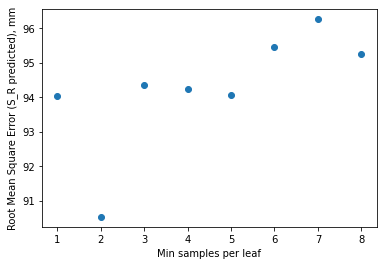

In [17]:
plt.scatter(min_leaves,rmses)
plt.ylabel('Root Mean Square Error (S_R predicted), mm')
plt.xlabel('Min samples per leaf')

Text(0.5, 0, 'Permutation feature importance')

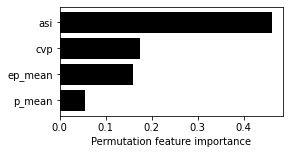

In [18]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(m_all, pred_df.values, target.values,random_state=87)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(4, 2))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], 
         align='center',color='black')
ytick_labels = ['ASI','Mean PET (mm/y)','Mean P (mm/y)','$CV_P$']
ytick_labels = predictors
plt.yticks(range(len(sorted_idx)), np.array(pred_df.columns)[sorted_idx])
plt.yticks(range(len(sorted_idx)), ytick_labels)

plt.xlabel('Permutation feature importance')

# sns.despine()
# plt.savefig(folder_path+'Figures/'+'feat_imp.pdf',bbox_inches='tight')

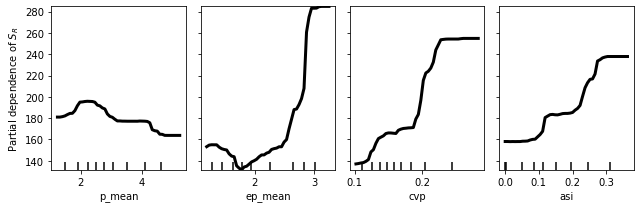

In [21]:
f, ax = plt.subplots(1, 4, figsize=(9,3), sharey=True)

pdp = PartialDependenceDisplay.from_estimator(
    m_all, pred_df.values, [0,1,2,3], 
    feature_names=predictors, 
    n_jobs=3, ax=ax, 
    grid_resolution=50, line_kw={'color':'black','lw':'3'})
# plt.ylim(300,500)
ax[0].set_ylabel('Partial dependence of $S_R$')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
x_labels = ['Mean P (mm/d)', 'Mean PET (mm/d)','$CV_P$','ASI']
x_labels = predictors
for i in range(len(ax)):
    ax[i].set_xlabel(x_labels[i])

# ax[2].set_xlim(0.2,0.5)
# ax[3].set_xlim(0.5,0.75)
f.tight_layout()
# sns.despine()
# plt.savefig(folder_path+'Figures/'+'partial_dependence.pdf',bbox_inches='tight')